In [2]:
# ======================
# 0. MAIN
# ======================
# main.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import datetime
import random

# TensorFlow / Keras for LSTM time series forecasting
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# ======================
# 1. Data Loading & Preprocessing
# ======================

# Update the file paths if your CSV files are in a different directory.
features = pd.read_csv("/Users/alstonhsu/Desktop/Purdue/2025_Spring/Module03/MGMT_69000_IP/datasetFromClient/dairy/csv/features-daily_2024-11_dairy.csv", 
                       parse_dates=['daydate', 'currentlastsalesdate', 'currentlastreceiptdate', 'lastsalesdate', 'storeDate'])
labels = pd.read_csv("/Users/alstonhsu/Desktop/Purdue/2025_Spring/Module03/MGMT_69000_IP/datasetFromClient/dairy/csv/labels_2024-11_dairy.csv", 
                     parse_dates=['storeDate', 'historyTime', 'outOfShelfTime', 'PlannedAbandonmentDate'])
trxn = pd.read_csv("/Users/alstonhsu/Desktop/Purdue/2025_Spring/Module03/MGMT_69000_IP/datasetFromClient/dairy/csv/trxn_2024-11_dairy.csv", 
                   parse_dates=['TransactionDate', 'TransactionTime', 'TransactionInitiatedTimestamp', 
                                'TransactionLineItemScanTimestamp', 'TransactionLineItemScanUTCTimestamp'])

# Remove holiday data (Thanksgiving) based on the assumption that Thanksgiving is on 2024-11-28.
# If you have more holiday dates or a different approach, update this section accordingly.
holiday_date = pd.Timestamp('2024-11-28')
features = features[features['daydate'] != holiday_date]
labels = labels[labels['storeDate'] != holiday_date]
trxn = trxn[trxn['TransactionDate'] != holiday_date]

# Drop duplicates if any
features.drop_duplicates(inplace=True)
labels.drop_duplicates(inplace=True)
trxn.drop_duplicates(inplace=True)

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_15649/2289677227.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trxn = pd.read_csv("/Users/alstonhsu/Desktop/Purdue/2025_Spring/Module03/MGMT_69000_IP/datasetFromClient/dairy/csv/trxn_2024-11_dairy.csv",


In [4]:
# ======================
# 2. Phantom Inventory Flagging
# ======================

# Aggregate the transaction data to the daily level per SKU.
# For example, summing total quantity and counting the number of transactions.
trxn_agg = trxn.groupby(['ItemSku', 'TransactionDate']).agg({
    'TotalItemQuantity': 'sum',    # Total quantity sold in transactions
    'TransactionId': 'nunique',    # Number of unique transactions
    'Quantity': 'sum',             # Alternatively, use Quantity if it captures sold units
    'VoidIndicator': 'sum'         # Sum here gives number of voided transactions per day
}).reset_index()

# Rename columns to align with the features dataset
trxn_agg.rename(columns={
    'ItemSku': 'itemsku', 
    'TransactionDate': 'daydate',
    'TotalItemQuantity': 'trxn_total_qty',
    'TransactionId': 'trxn_count',
    'Quantity': 'trxn_quantity',
    'VoidIndicator': 'void_count'
}, inplace=True)

# Merge aggregated transaction data with features based on itemsku and daydate.
features = features.merge(trxn_agg, on=['itemsku', 'daydate'], how='left')
# Fill missing transaction data with 0. # Fill missing values (i.e., days with no transactions) with 0
features['trxn_total_qty'] = features['trxn_total_qty'].fillna(0)
features['trxn_count'] = features['trxn_count'].fillna(0)
features['trxn_quantity'] = features['trxn_quantity'].fillna(0)
features['void_count'] = features['void_count'].fillna(0)

# Merge the features and labels data on product identifier and date.
# Here, we assume the join keys are: 'itemsku' in features and 'ItemSku' in labels,
# and that 'daydate' in features corresponds to 'storeDate' in labels.
merged = pd.merge(
    features, 
    labels, 
    left_on=['itemsku', 'daydate'], 
    right_on=['ItemSku', 'storeDate'], 
    how='left')

# Merge aggregated transaction data with the merged features/labels dataset.
merged = pd.merge(merged, trxn_agg, on=['itemsku', 'daydate'], how='left')

# Rule 1: If the product is flagged as out-of-shelf in labels (i.e. outOfShelf is True) 
# and the reported current balance on hand (DailyBOH) is greater than 0,
# then it may be a phantom inventory.
merged['phantom_flag'] = np.where((merged['outOfShelf'] == True) & (merged['DailyBOH'] > 0), 1, 0)

# Rule 2 (alternative/additional): If, for example, the product is reported as in-stock (PositiveBOHFlag==1),
# but there are no sales (salesQuantity == 0) and there is an out-of-stock count (OOSCount > 0),
# then flag it as phantom.
merged['phantom_flag'] = np.where( (merged['phantom_flag'] == 1) | 
                                   ((merged['PositiveBOHFlag'] == 1) & 
                                    (merged['salesQuantity'] == 0) & 
                                    (merged['OOSCount'] > 0)), 1, 0)

In [ ]:
# ======================
# Use THIS. Updated Features Engineering
# ======================

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# # We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.         [[[*** DATA LEAKAGE***]]]
# kmeans = KMeans(n_clusters=3, random_state=42)
# merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/3242313531.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)
/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/3242313531.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Confusion Matrix:
[[26667   205]
 [  586  1985]] 

Precision for phantom class (Class 1):
0.906392694063927 

Recall for Class 1:
0.7721
F1 Score: 0.8338584331022895 

Test Accuracy: 0.9731345311279421 

Confusion Matrix:


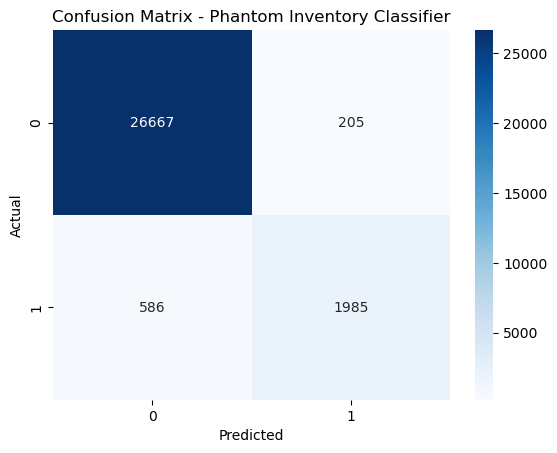

In [16]:
# ======================
# 3. Clustering and Classification Modeling (w/ Features Engineering)
# ======================

# Optional approach for moderate missing columns in "avg_sales_50to8" features directly but loss some info:
# merged["avg_sales_50to8"].fillna(0, inplace=True)
# merged["avg_sales_last7"].fillna(0, inplace=True)

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Impute the missing values with median or 0
impute_val = merged['avg_sales_50to8'].median()  # or 0
merged['avg_sales_50to8_imputed'] = merged['avg_sales_50to8'].fillna(impute_val)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# Impute missing 'avg_sales_last7' values with the median (or another strategy)
impute_val_last7 = merged['avg_sales_last7'].median()
merged['avg_sales_last7_imputed'] = merged['avg_sales_last7'].fillna(impute_val_last7)

# So, we include 'avg_sales_last7_imputed' and 'avg_sales_last7_missing' 
# in our model’s feature list instead of the raw 'avg_sales_last7'.

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 3. SKU-level median fill for any remaining missing values
sku_median_boh = merged.groupby("itemsku")["CurrentBOH"].transform(lambda x: x.fillna(x.median()))
merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)

# 4. If still missing, fill with overall median
merged["CurrentBOH"].fillna(merged["CurrentBOH"].median(), inplace=True)
# Now include "CurrentBOH_missing" as a feature in the model.

# # Option 1: Impute missing values with 0, assuming missing implies no backroom inventory.
# merged["IMSQuantity_imputed"] = features["IMSQuantity"].fillna(0)

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 5. Stock Turnover Ratio:
#    Rolling 7-day sum of ShippedQuantity divided by DailyBOH.
merged["rolling_shipped_7d"] = merged.groupby("itemsku")["ShippedQuantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).sum())
merged["stock_turnover_ratio_7d"] = merged["rolling_shipped_7d"] / (merged["DailyBOH"] + 1)

# 6. Days Since Last Sale Flag:
#    Flag if DaysSinceLastSale exceeds the median for that SKU.
if "DaysSinceLastSale" in merged.columns:
    median_days = merged.groupby("itemsku")["DaysSinceLastSale"].transform("median")
    merged["days_since_last_sale_flag"] = (merged["DaysSinceLastSale"] > median_days).astype(int)
else:
    merged["days_since_last_sale_flag"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
                   'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
                   'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

# # Fill missing values in selected features with 0
# model_data[feature_columns] = model_data[feature_columns].fillna(0)

# Split into training and test sets
X = model_data[feature_columns]
y = model_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier.
# The class_weight parameter is set to give more importance to class 1 (phantom) to boost precision.
rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})
rf.fit(X_train, y_train)

# Evaluate the classifier using a custom threshold
# Get predicted probabilities for the phantom class (Class 1)
y_proba = rf.predict_proba(X_test)[:, 1]

# Set your custom threshold (0.7 in this case / 0.57 for a balanced)
threshold = 0.7

# Generate binary predictions based on the custom threshold
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Define your custom colors from lightest to darkest
colors = ["#cbc2a2", "#db9735", "#60523a"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Evaluate the classifier using these adjusted predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted), "\n")

print("Precision for phantom class (Class 1):")
print(precision_score(y_test, y_pred_adjusted, pos_label=1), "\n")

recall = recall_score(y_test, y_pred_adjusted, pos_label=1)
print(f"Recall for Class 1:\n{recall:.4f}")

f1 = f1_score(y_test, y_pred_adjusted, pos_label=1)
print("F1 Score:", f1, "\n")

accuracy = accuracy_score(y_test, y_pred_adjusted)
print("Test Accuracy:", accuracy, "\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Phantom Inventory Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()







# ######### Grow Trees
# # Get ensemble predicted probabilities for the phantom class on the test set
# ensemble_proba = rf.predict_proba(X_test)[:, 1]

# # List to store the correlation values for each tree
# tree_correlations = []

# # Loop through each tree in the Random Forest
# for i, tree in enumerate(rf.estimators_):
#     # Get the predicted probabilities for the phantom class from the individual tree
#     tree_proba = tree.predict_proba(X_test)[:, 1]
#     # Calculate Pearson correlation coefficient between the tree's predictions and the ensemble's predictions
#     correlation = np.corrcoef(ensemble_proba, tree_proba)[0, 1]
#     tree_correlations.append(correlation)
#     print(f"Tree {i}: correlation with ensemble = {correlation:.4f}")

# # Identify the tree with the highest correlation
# most_influential_index = np.argmax(tree_correlations)
# print(f"\nMost influential tree is tree {most_influential_index} with correlation {tree_correlations[most_influential_index]:.4f}")





# from sklearn.tree import export_graphviz
# import graphviz

# # Export the most influential tree to DOT format with limited depth.
# dot_data_limited = export_graphviz(
#     rf.estimators_[most_influential_index],
#     out_file=None,
#     feature_names=feature_columns,
#     class_names=['Not Phantom', 'Phantom'],
#     filled=True,
#     rounded=True,
#     special_characters=True,
#     max_depth=3  # Limit the depth to 3 for readability
# )

# # Create a Graphviz graph from the DOT data and render as PNG.
# graph_limited = graphviz.Source(dot_data_limited)
# graph_limited.render("most_influential_tree_limited", format='png', cleanup=True)
# print("Most influential tree diagram (limited depth) saved as 'most_influential_tree_limited.png'.")
# graph_limited  # In a Jupyter Notebook, this displays the diagram inline.








# from sklearn.tree import export_graphviz
# import graphviz

# # Export the full most influential tree to DOT format.
# dot_data_full = export_graphviz(
#     rf.estimators_[most_influential_index],
#     out_file=None,
#     feature_names=feature_columns,
#     class_names=['Not Phantom', 'Phantom'],
#     filled=True,
#     rounded=True,
#     special_characters=True
# )

# # Create a Graphviz graph from the DOT data and render as PDF.
# graph_full = graphviz.Source(dot_data_full)
# graph_full.render("most_influential_tree_full", format='pdf', cleanup=True)
# print("Most influential tree diagram (full tree) saved as 'most_influential_tree_full.pdf'.")

In [ ]:
# 3. [ RF ] Clustering and Classification Modeling (w/ Features Engineering) ((NEW 250417))
# ======================

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# # We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.         [[[*** DATA LEAKAGE***]]]
# kmeans = KMeans(n_clusters=3, random_state=42)
# merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy',
                   'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
import numpy as np

# ------------------------------
# 1.  Train–test split *by SKU* or *by date* (pick one)
# ------------------------------
X = model_data[feature_columns]
y = model_data[target_column]
groups = model_data['itemsku']          #  or daydate.dt.date if doing time splits
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=0.2, random_state=42, stratify=y)

# ------------------------------
# 2.  Pre‑processing & model
# ------------------------------
cat_cols = ['DayofWeek']
num_cols = [c for c in feature_columns if c not in cat_cols]

pre = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

rf = RandomForestClassifier(
        n_estimators=800,
        max_depth=10,
        min_samples_leaf=20,
        max_features=0.3,
        bootstrap=True,
        oob_score=True,
        class_weight={0:1, 1:4},
        random_state=42
)

pipe = Pipeline([('prep', pre),
                 ('rf',   rf)])


# ------------------------------
# 3.  Cross‑validation without leakage
# ------------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe, X_train, y_train, groups=g_train,
                      cv=cv, scoring='roc_auc')
print(f'CV ROC‑AUC mean ± std: {auc.mean():.3f} ± {auc.std():.3f}')

# ------------------------------
# 4.  Hyper‑parameter search (optional)
# ------------------------------
param_dist = {
    'rf__n_estimators':  randint(400, 1200),
    'rf__max_depth':     randint(5, 15),
    'rf__min_samples_leaf': randint(5, 50),
    'rf__max_features':  uniform(0.2, 0.4)  #  0.2–0.6
}
search = RandomizedSearchCV(pipe, param_dist,
                            n_iter=20, cv=cv, n_jobs=-1,
                            scoring='roc_auc', random_state=42)
search.fit(X_train, y_train, groups=g_train)
best_model = search.best_estimator_
print('Best CV ROC‑AUC:', search.best_score_)

# ------------------------------
# 5.  Fit best model on full train, then tune threshold
# ------------------------------
best_model.fit(X_train, y_train)
proba = best_model.predict_proba(X_train)[:,1]

# prec, rec, thr = precision_recall_curve(y_train, proba)
# f1 = 2*prec*rec/(prec+rec)
# best_thr = thr[np.argmax(f1)]
# print(f'Best threshold for F1 = {best_thr:.2f}, F1 = {f1.max():.3f}')

from sklearn.metrics import precision_recall_curve

proba_val = best_model.predict_proba(X_train)[:, 1]   # or use a CV‑held fold
prec, rec, thr = precision_recall_curve(y_train, proba_val)

# Find the *smallest* threshold that gets you precision ≥ 0.90
target_p  = 0.90
idx       = np.where(prec[:-1] >= target_p)[0]
if len(idx):
    best_thr_p90 = thr[idx[0]]
    print(f'Precision≥0.90 threshold = {best_thr_p90:.2f}, '
          f'Precision = {prec[idx[0]]:.3f}, Recall = {rec[idx[0]]:.3f}')
else:
    print('Model never reaches 0.90 precision')

# ------------------------------
# 6.  Evaluate on the untouched test set
# ------------------------------
proba_test = best_model.predict_proba(X_test)[:,1]
y_pred = (proba_test >= best_thr_p90).astype(int)
print('Test F1:', f1_score(y_test, y_pred))
print('Test recall:', recall_score(y_test, y_pred))
print('Test precision:', precision_score(y_test, y_pred))
print('Test ROC‑AUC:', roc_auc_score(y_test, proba_test))

CV ROC‑AUC mean ± std: 0.832 ± 0.025
Best CV ROC‑AUC: 0.8338951260534019
Precision≥0.90 threshold = 0.43, Precision = 0.900, Recall = 0.586
Test F1: 0.7083529966965549
Test recall: 0.5838195254764683
Test precision: 0.9004199160167966
Test ROC‑AUC: 0.9344825763441802


[LightGBM] [Info] Number of positive: 8667, number of negative: 85125
[LightGBM] [Info] Number of positive: 7339, number of negative: 83821
[LightGBM] [Info] Number of positive: 8677, number of negative: 87453
[LightGBM] [Info] Number of positive: 8142, number of negative: 85903
[LightGBM] [Info] Number of positive: 8307, number of negative: 87650
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 96130, number of used features: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] [binary:BoostFromSc

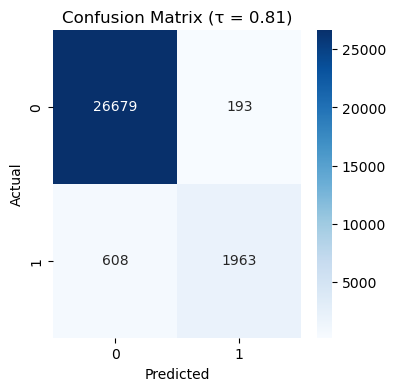

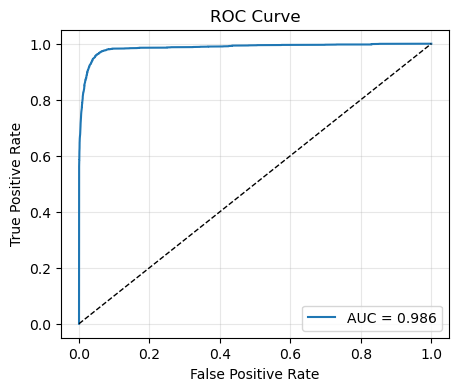

In [ ]:
# [ LightGBM ] 3. Clustering and Classification Modeling (w/ Features Engineering) ((NEW 250417))
# ======================

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# # We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.         [[[*** DATA LEAKAGE***]]]
# kmeans = KMeans(n_clusters=3, random_state=42)
# merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy',
                   'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

# ----------------------------------------
# 0.  Imports
# ----------------------------------------
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
        StratifiedGroupKFold, train_test_split, cross_val_score,
        RandomizedSearchCV)
from sklearn.metrics import (
        precision_recall_curve, f1_score, precision_score,
        recall_score, roc_auc_score)
import numpy as np
import pandas as pd

# ----------------------------------------
# 1.  Train / test split
# ----------------------------------------
X = model_data[feature_columns]
y = model_data[target_column]
groups = model_data['itemsku']

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=0.2, random_state=42, stratify=y)

# ----------------------------------------
# 2.  Pre‑processing
# ----------------------------------------
cat_cols = ['DayofWeek']
num_cols = [c for c in X_train.columns if c not in cat_cols]

pre = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# ----------------------------------------
# 3.  LightGBM base model
# ----------------------------------------
lgbm = LGBMClassifier(
        objective='binary',
        n_estimators=300,       # 2000 for the deployment
        learning_rate=0.15,     # 0.05 for the deployment
        num_leaves=64,
        max_depth=-1,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.6,
        scale_pos_weight=4,          # imbalance handle (tune)
        random_state=42,
        n_jobs=-1)

pipe_lgb = Pipeline([
        ('prep', pre),
        ('lgb',  lgbm)
])

# ----------------------------------------
# 4.  Cross‑validation (no leakage)
# ----------------------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe_lgb, X_train, y_train,
                      groups=g_train, cv=cv,
                      scoring='roc_auc', n_jobs=-1)
print(f'CV ROC‑AUC mean ± std: {auc.mean():.3f} ± {auc.std():.3f}')

# ----------------------------------------
# 5.  Light hyper‑parameter search (15 iter, ~5‑10 min)
#     Feel free to increase n_iter if you have time.
# ----------------------------------------
param_dist = {
    'lgb__num_leaves'       : np.arange(32, 97, 16),
    'lgb__min_child_samples': [10, 20, 30, 40],
    'lgb__subsample'        : [0.7, 0.8, 0.9],
    'lgb__colsample_bytree' : [0.5, 0.6, 0.7],
    'lgb__scale_pos_weight' : [3, 4, 5]
}

search = RandomizedSearchCV(
        pipe_lgb, param_dist,
        n_iter=10, cv=cv, n_jobs=-1,
        scoring='roc_auc', random_state=42, verbose=1)

search.fit(X_train, y_train, groups=g_train)
best_model = search.best_estimator_
print('Best CV ROC‑AUC:', search.best_score_)

# ----------------------------------------
# 6.  Pick threshold for Precision ≥ 0.90
# ----------------------------------------
from sklearn.metrics import (
    precision_recall_curve, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)
import numpy as np

def eval_with_precision_floor(model,
                              X_ref, y_ref,
                              X_test, y_test,
                              floor=0.93, verbose=True):
    """
    Choose the *smallest* threshold that reaches 'floor' precision on X_ref/y_ref,
    then evaluate on X_test/y_test.

    Returns (threshold, metrics_dict)
    """
    # ---------- 1) choose threshold on reference set ----------
    p_ref = model.predict_proba(X_ref)[:, 1]
    prec, rec, thr = precision_recall_curve(y_ref, p_ref)

    # thr has length = len(prec) - 1.  We want the first τ s.t. P(τ) ≥ floor
    idx = np.where(prec[:-1] >= floor)[0]
    if len(idx) == 0:
        raise ValueError(f"Model never reaches precision {floor:.2f}")
    tau = thr[idx[0]]

    # ---------- 2) evaluate on test set ----------
    p_test = model.predict_proba(X_test)[:, 1]
    y_hat  = (p_test >= tau).astype(int)

    metrics = {
        "precision": precision_score(y_test, y_hat),
        "recall"   : recall_score(y_test, y_hat),
        "f1"       : f1_score(y_test, y_hat),
        "roc_auc"  : roc_auc_score(y_test, p_test),
        "threshold": tau,
        "cm"       : confusion_matrix(y_test, y_hat)
    }
    if verbose:
        print(f"Threshold @P≥{floor:.2f} (chosen on ref): {tau:.2f}")
        print("Test metrics:", {k: round(v, 3) if k!='cm' else v
                               for k, v in metrics.items()
                               if k!='threshold'})
    return tau, metrics

tau, metrics = eval_with_precision_floor(best_model,
                                         X_ref=X_train, y_ref=y_train,   # or a held‑out 10 % slice
                                         X_test=X_test, y_test=y_test,
                                         floor=0.93)

# ----------------------------------------
# 7.  Final test‑set evaluation
# ----------------------------------------
proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= tau).astype(int)

print('Test Precision:', precision_score(y_test, y_pred))
print('Test Recall   :', recall_score(y_test, y_pred))
print('Test F1       :', f1_score(y_test, y_pred))
print('Test ROC‑AUC  :', roc_auc_score(y_test, proba_test))

# ----------------------------------------
# 7.  Plotting
# ----------------------------------------
threshold = 0.81       # Precision ≥ 0.90 the cut‑off
y_proba   = best_model.predict_proba(X_test)[:, 1]
y_pred    = (y_proba >= threshold).astype(int)

# 1) Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (τ = {:.2f})'.format(threshold))
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

[LightGBM] [Info] Number of positive: 8667, number of negative: 85125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 93792, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092407 -> initscore=-2.284598
[LightGBM] [Info] Start training from score -2.284598
[LightGBM] [Info] Number of positive: 7339, number of negative: 83821
[LightGBM] [Info] Number of positive: 8677, number of negative: 87453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in 

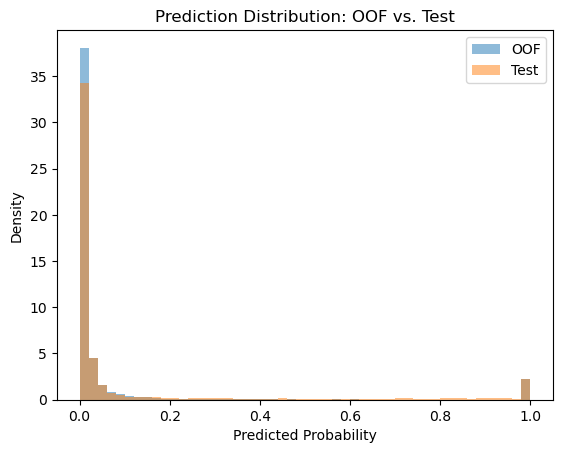

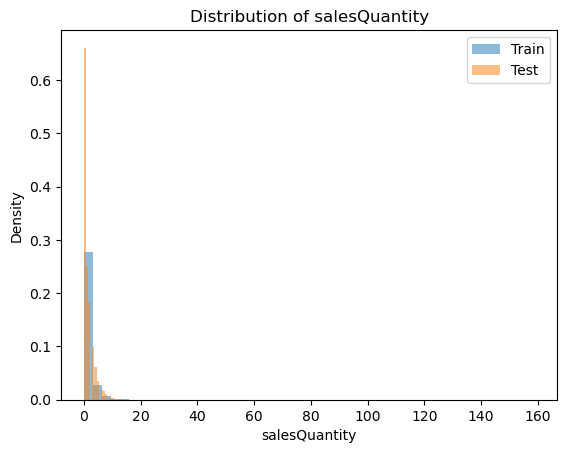

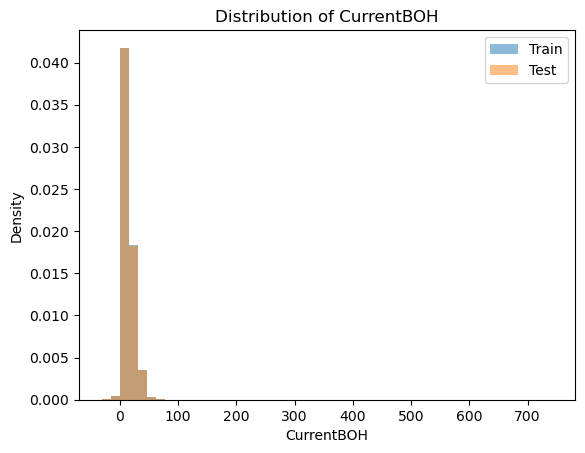

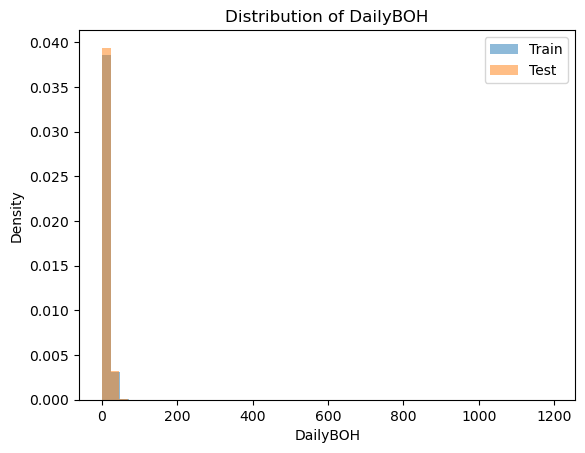

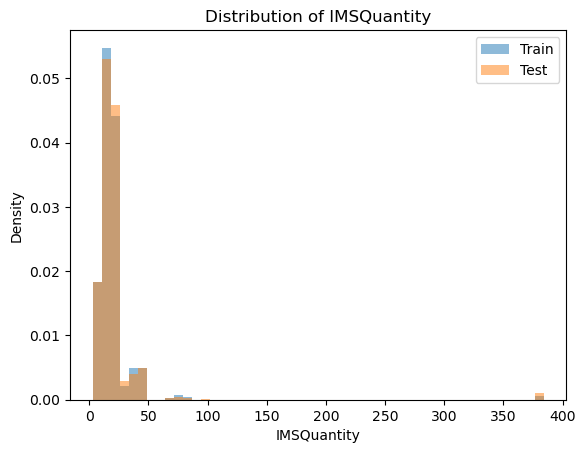

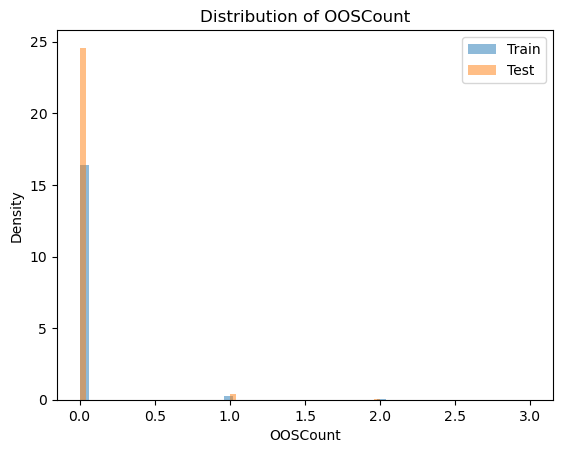

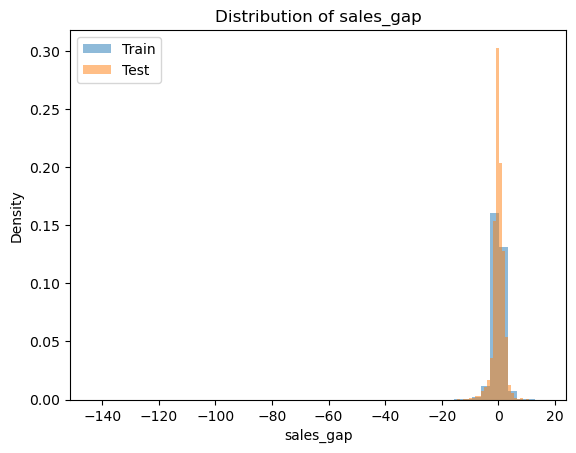

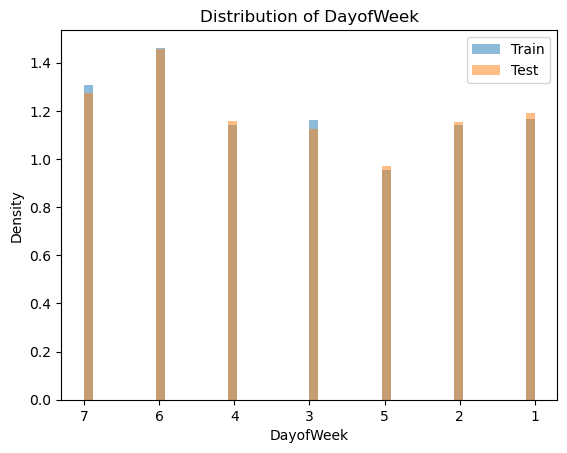

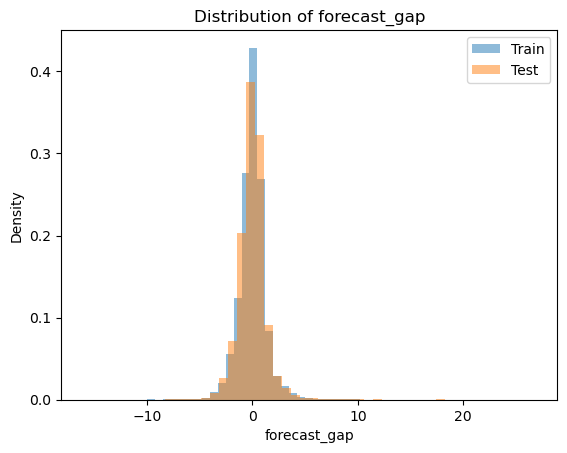

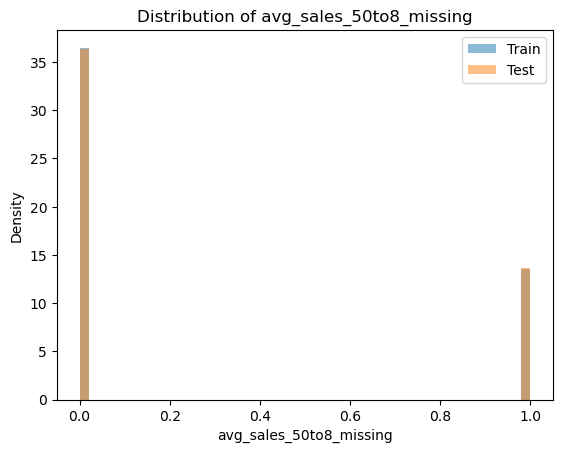

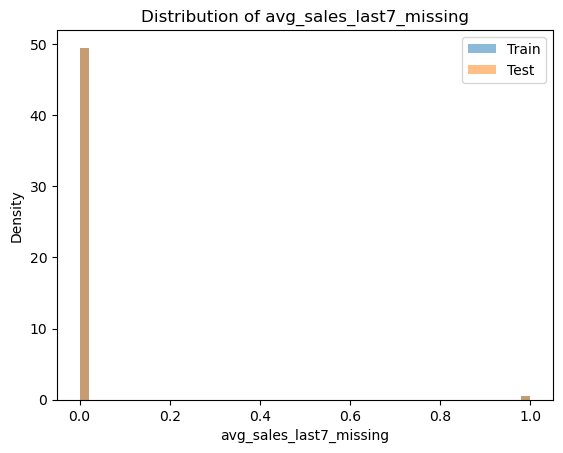

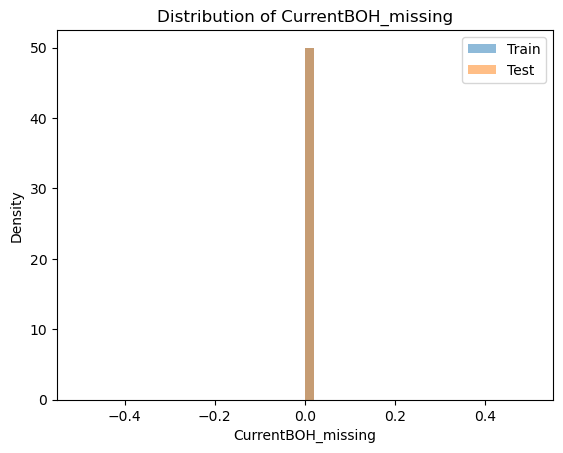

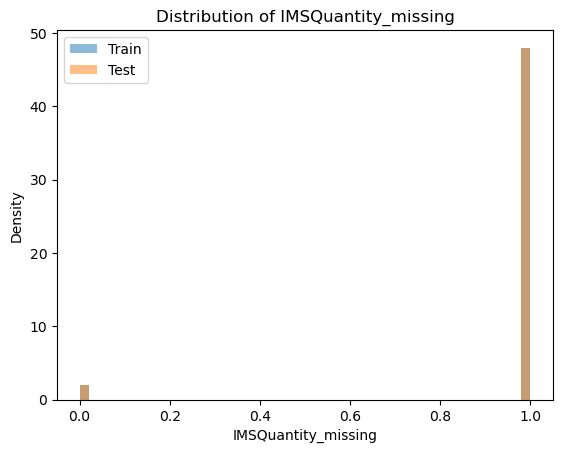

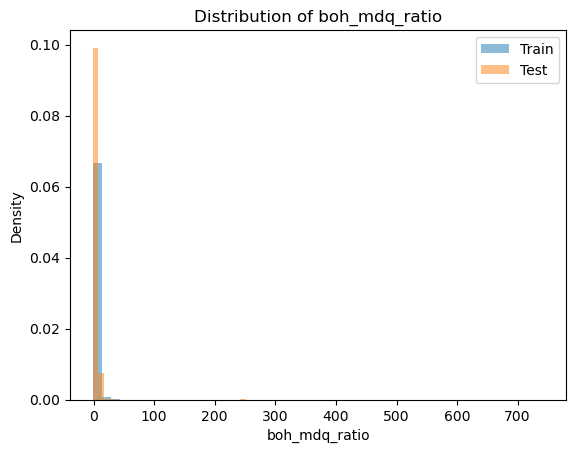

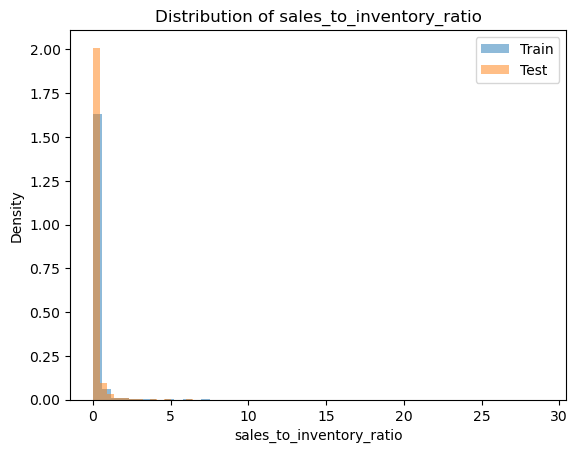

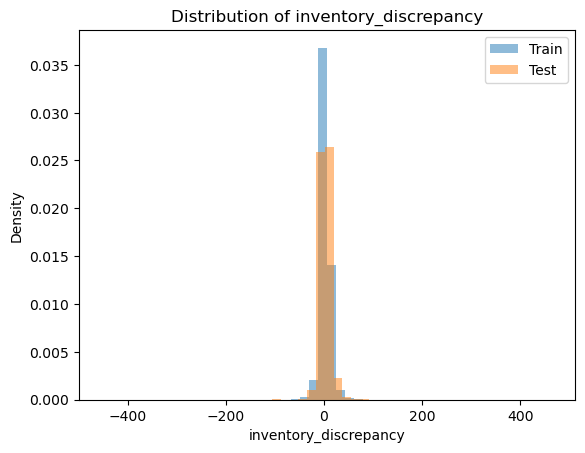

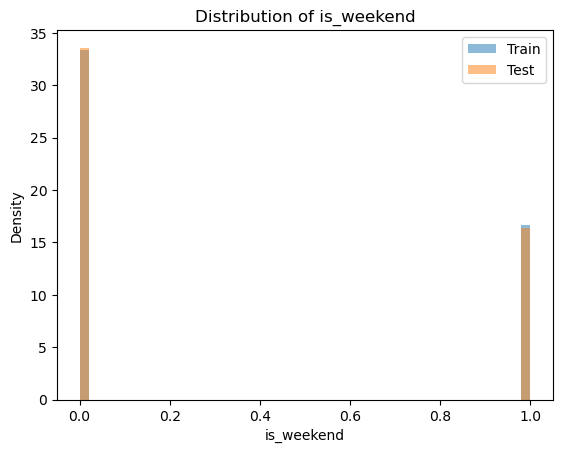

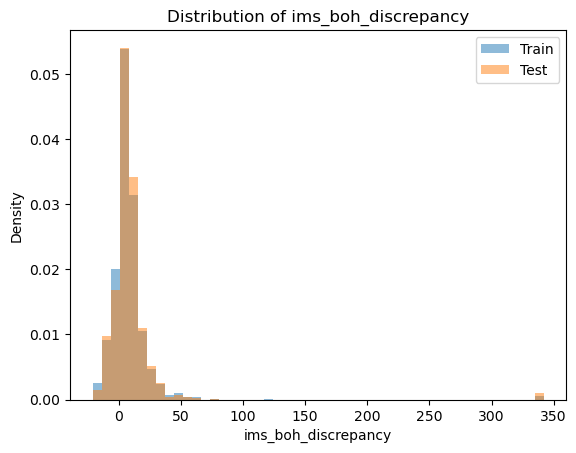

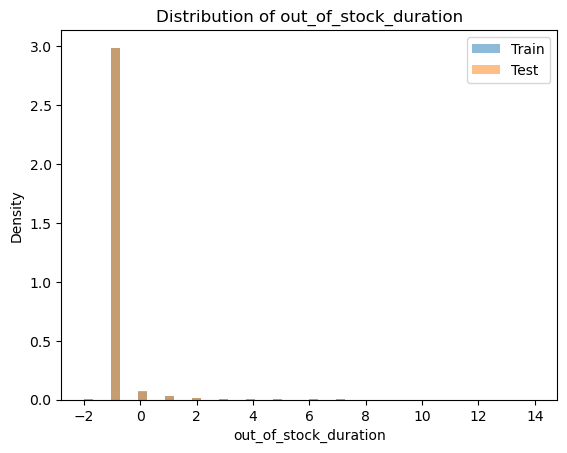

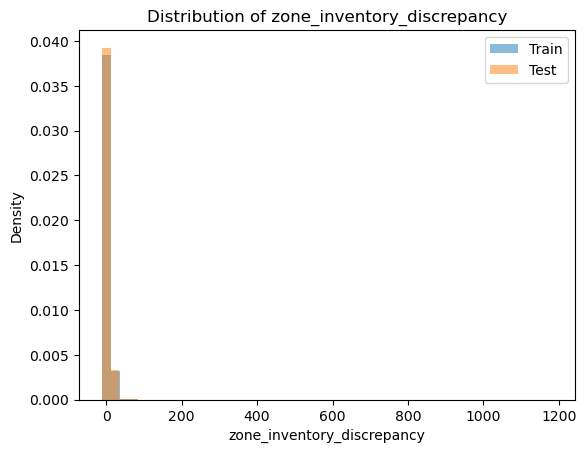

[LightGBM] [Info] Number of positive: 8226, number of negative: 85990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 94216, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087310 -> initscore=-2.346931
[LightGBM] [Info] Start training from score -2.346931
New Hold‑Out AUC: 0.9835052659814868
LightGBM complexity parameters:
  n_estimators      : 300
  learning_rate     : 0.15
  num_leaves        : 48
  max_depth         : -1
  min_child_samples : 20
  subsample         : 0.8
  colsample_bytree  : 0.7
  scale_pos_weight  : 4


In [ ]:
# ─── Insert this after your RandomizedSearchCV & final proba_test ───

from sklearn.model_selection import cross_val_predict

# 1) Generate OOF predictions on your training fold
oof_preds = cross_val_predict(
    best_model,              # your tuned Pipeline
    X_train, y_train,
    groups=g_train,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# 2) Grab your test‐set probabilities (you already computed this)
test_preds = proba_test      # shape = (n_test_samples,)

# 3) Build simple DataFrames for distribution checks
train_df = X_train.copy()
train_df[target_column] = y_train.values

test_df  = X_test.copy()
test_df[target_column] = y_test.values

# 4) List of features to loop over
features = feature_columns    # as you defined at the top

# ─── Evaluation 1: Compare OOF vs. Test Prediction Distributions ───
# Quick sanity‐check prints
print("OOF preds shape:", oof_preds.shape)
print("Test preds shape:", test_preds.shape)
print("train_df columns:", train_df.columns.tolist()[:5], "…")
print("test_df columns :", test_df.columns.tolist()[:5], "…")
print("Number of features:", len(features))

import matplotlib.pyplot as plt

plt.hist(oof_preds, bins=50, density=True, alpha=0.5, label='OOF')
plt.hist(test_preds, bins=50, density=True, alpha=0.5, label='Test')
plt.legend()
plt.title('Prediction Distribution: OOF vs. Test')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()

# ─── Evaluation 2: Check Feature Distribution Drift ───
# train_df / test_df: DataFrames containing the same feature columns
# features: a list of column names you want to inspect
for feat in features:
    plt.figure()
    plt.hist(train_df[feat], bins=50, density=True, alpha=0.5, label='Train')
    plt.hist(test_df[feat],  bins=50, density=True, alpha=0.5, label='Test')
    plt.legend()
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.show()

# ─── Evaluation 3: Sanity‑Check with a New Hold‑Out Split ───
from sklearn.model_selection import train_test_split
from sklearn.metrics        import roc_auc_score
from sklearn.base           import clone

# Carve out a new hold‑out set from your original training data
X_subtrain, X_holdout, y_subtrain, y_holdout = train_test_split(
    X_train, y_train,
    test_size=0.20,
    random_state=123,
    stratify=y_train
)

# Clone your tuned pipeline and retrain on the sub‑training set
model_temp = clone(best_model)
model_temp.fit(X_subtrain, y_subtrain)

# Evaluate on the new hold‑out set
y_holdout_proba = model_temp.predict_proba(X_holdout)[:, 1]
print('New Hold‑Out AUC:', roc_auc_score(y_holdout, y_holdout_proba))

# ─── Evaluation 4: Inspect / Monitor Model Complexity ───
# Extract LightGBM parameters from your best pipeline
lgb_params = best_model.named_steps['lgb'].get_params()

print("LightGBM complexity parameters:")
print(f"  n_estimators      : {lgb_params['n_estimators']}")
print(f"  learning_rate     : {lgb_params['learning_rate']}")
print(f"  num_leaves        : {lgb_params['num_leaves']}")
print(f"  max_depth         : {lgb_params['max_depth']}")
print(f"  min_child_samples : {lgb_params['min_child_samples']}")
print(f"  subsample         : {lgb_params['subsample']}")
print(f"  colsample_bytree  : {lgb_params['colsample_bytree']}")
print(f"  scale_pos_weight  : {lgb_params['scale_pos_weight']}")

Training AUC: 0.9954
Validation AUC: 0.9828


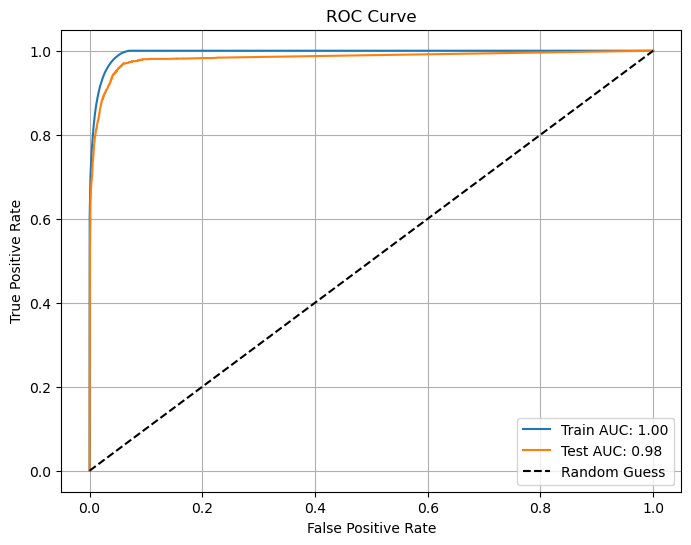

Cross-validated AUC scores: [0.90872116 0.8719667  0.86843825 0.86411325 0.83711535]
Mean cross-validated AUC: 0.8701


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

# Assume rf is your trained XGBoost model, and X_train, X_test, y_train, y_test are already defined.

# --- Evaluate Training vs. Validation AUC ---

# Predict probabilities on the training set
y_train_pred_proba = rf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Predict probabilities on the test (validation) set
y_test_pred_proba = rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Training AUC: {:.4f}".format(train_auc))
print("Validation AUC: {:.4f}".format(test_auc))

# --- Plot ROC Curves for Training and Test Sets ---

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC: {train_auc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC: {test_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Cross-Validated AUC Scores ---

# Perform 5-fold cross-validation with ROC AUC as the scoring metric.
cv_auc_scores = cross_val_score(rf, X, y, cv=5, scoring="roc_auc")
print("Cross-validated AUC scores:", cv_auc_scores)
print("Mean cross-validated AUC: {:.4f}".format(cv_auc_scores.mean()))

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_30818/2705640885.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)
/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_30818/2705640885.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Confusion Matrix:
[[16480    23]
 [ 1115   899]] 

Precision for phantom class (Class 1): 0.9751
Recall for phantom class (Class 1):    0.4464
F1 Score:                              0.6124
Test Accuracy:                         0.9385


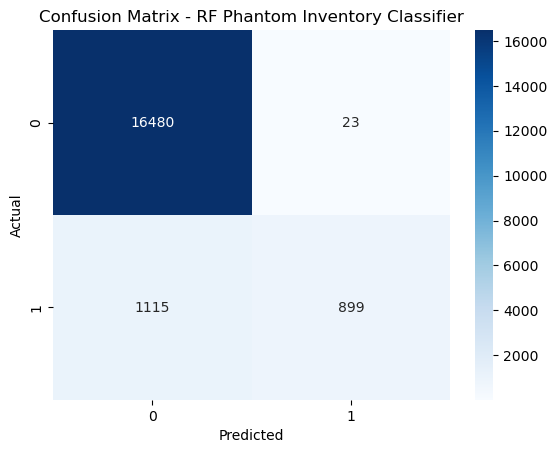

In [73]:
# rf w/ data sequential

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Impute the missing values with median or 0
impute_val = merged['avg_sales_50to8'].median()  # or 0
merged['avg_sales_50to8_imputed'] = merged['avg_sales_50to8'].fillna(impute_val)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# Impute missing 'avg_sales_last7' values with the median (or another strategy)
impute_val_last7 = merged['avg_sales_last7'].median()
merged['avg_sales_last7_imputed'] = merged['avg_sales_last7'].fillna(impute_val_last7)

# So, we include 'avg_sales_last7_imputed' and 'avg_sales_last7_missing' 
# in our model’s feature list instead of the raw 'avg_sales_last7'.

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 3. SKU-level median fill for any remaining missing values
sku_median_boh = merged.groupby("itemsku")["CurrentBOH"].transform(lambda x: x.fillna(x.median()))
merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)

# 4. If still missing, fill with overall median
merged["CurrentBOH"].fillna(merged["CurrentBOH"].median(), inplace=True)
# Now include "CurrentBOH_missing" as a feature in the model.

# # Option 1: Impute missing values with 0, assuming missing implies no backroom inventory.
# merged["IMSQuantity_imputed"] = features["IMSQuantity"].fillna(0)

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 5. Stock Turnover Ratio:
#    Rolling 7-day sum of ShippedQuantity divided by DailyBOH.
merged["rolling_shipped_7d"] = merged.groupby("itemsku")["ShippedQuantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).sum())
merged["stock_turnover_ratio_7d"] = merged["rolling_shipped_7d"] / (merged["DailyBOH"] + 1)

# 6. Days Since Last Sale Flag:
#    Flag if DaysSinceLastSale exceeds the median for that SKU.
if "DaysSinceLastSale" in merged.columns:
    median_days = merged.groupby("itemsku")["DaysSinceLastSale"].transform("median")
    merged["days_since_last_sale_flag"] = (merged["DaysSinceLastSale"] > median_days).astype(int)
else:
    merged["days_since_last_sale_flag"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Ensure date columns in the merged DataFrame are in datetime format
model_data = merged.copy()  # Assuming 'merged' already contains your engineered features and target
model_data['daydate'] = pd.to_datetime(model_data['daydate'], errors='coerce')

# Define sequential split boundaries (same as your XGBoost code)
train_start    = '2024-11-01'
train_end_date = '2024-11-19'
val_end_date   = '2024-11-23'
test_end_date  = '2024-11-27'

# Create sequential training, validation, and test sets
train_data = model_data[(model_data['daydate'] >= train_start) & (model_data['daydate'] <= train_end_date)]
val_data   = model_data[(model_data['daydate'] > train_end_date) & (model_data['daydate'] <= val_end_date)]
test_data  = model_data[(model_data['daydate'] > val_end_date) & (model_data['daydate'] <= test_end_date)]

# Select your features and target (using the same feature_columns and target_column as before)
# (Ensure that non-numeric categorical features are converted similarly as before)
feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
                   'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
                   'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration',
                   'zone_inventory_discrepancy']
target_column = 'phantom_flag'

# If any of the feature columns are of object type, convert them to numerical codes
for col in feature_columns:
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype('category').cat.codes
        val_data[col] = val_data[col].astype('category').cat.codes
        test_data[col] = test_data[col].astype('category').cat.codes

# Prepare training and test datasets
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Optionally, you may also prepare a validation set (e.g., for hyperparameter tuning)
X_val = val_data[feature_columns]
y_val = val_data[target_column]

# Train the Random Forest classifier using the original structure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})
rf.fit(X_train, y_train)

# Get predicted probabilities for the phantom class (Class 1)
y_proba = rf.predict_proba(X_test)[:, 1]

# Set your custom threshold (0.7 here, or adjust as needed)
threshold = 0.7
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate the classifier
cm = confusion_matrix(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted, pos_label=1)
recall = recall_score(y_test, y_pred_adjusted, pos_label=1)
f1 = f1_score(y_test, y_pred_adjusted, pos_label=1)
accuracy = accuracy_score(y_test, y_pred_adjusted)

print("Confusion Matrix:")
print(cm, "\n")
print("Precision for phantom class (Class 1): {:.4f}".format(precision))
print("Recall for phantom class (Class 1):    {:.4f}".format(recall))
print("F1 Score:                              {:.4f}".format(f1))
print("Test Accuracy:                         {:.4f}".format(accuracy))

# Plot the Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - RF Phantom Inventory Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_15649/2639205984.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)
/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_15649/2639205984.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Epoch 1/64


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9372 - loss: 0.2545 - val_accuracy: 0.9515 - val_loss: 0.1849
Epoch 2/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9511 - loss: 0.1826 - val_accuracy: 0.9538 - val_loss: 0.1757
Epoch 3/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9528 - loss: 0.1733 - val_accuracy: 0.9545 - val_loss: 0.1677
Epoch 4/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9544 - loss: 0.1655 - val_accuracy: 0.9558 - val_loss: 0.1619
Epoch 5/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9557 - loss: 0.1598 - val_accuracy: 0.9569 - val_loss: 0.1573
Epoch 6/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9563 - loss: 0.1548 - val_accuracy: 0.9573 - val_loss: 0.1530
Epoch 7/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9567 - loss: 0.1501 - val_accuracy: 0.9572 - val_loss: 0.1492
Epoch 8/64
2945/2945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9573 - loss: 0.1459 - val_accurac

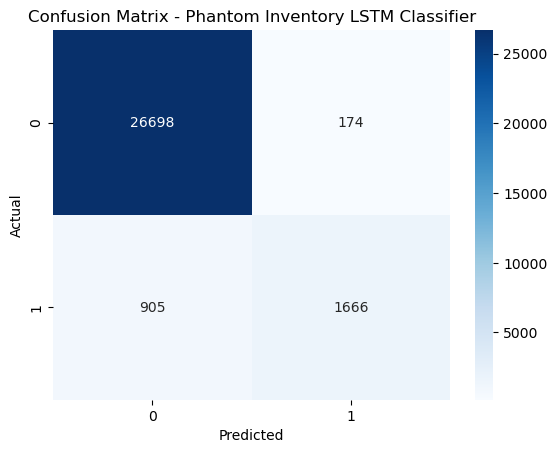

In [30]:
# 3.X Clustering and Classification Modeling (w/ Features Engineering) *** using LSTM ***
# ======================

# Optional approach for moderate missing columns in "avg_sales_50to8" features directly but loss some info:
# merged["avg_sales_50to8"].fillna(0, inplace=True)
# merged["avg_sales_last7"].fillna(0, inplace=True)

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Impute the missing values with median or 0
impute_val = merged['avg_sales_50to8'].median()  # or 0
merged['avg_sales_50to8_imputed'] = merged['avg_sales_50to8'].fillna(impute_val)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# Impute missing 'avg_sales_last7' values with the median (or another strategy)
impute_val_last7 = merged['avg_sales_last7'].median()
merged['avg_sales_last7_imputed'] = merged['avg_sales_last7'].fillna(impute_val_last7)

# So, we include 'avg_sales_last7_imputed' and 'avg_sales_last7_missing' 
# in our model’s feature list instead of the raw 'avg_sales_last7'.

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 3. SKU-level median fill for any remaining missing values
sku_median_boh = merged.groupby("itemsku")["CurrentBOH"].transform(lambda x: x.fillna(x.median()))
merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)

# 4. If still missing, fill with overall median
merged["CurrentBOH"].fillna(merged["CurrentBOH"].median(), inplace=True)
# Now include "CurrentBOH_missing" as a feature in the model.

# # Option 1: Impute missing values with 0, assuming missing implies no backroom inventory.
# merged["IMSQuantity_imputed"] = features["IMSQuantity"].fillna(0)

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 5. Stock Turnover Ratio:
#    Rolling 7-day sum of ShippedQuantity divided by DailyBOH.
merged["rolling_shipped_7d"] = merged.groupby("itemsku")["ShippedQuantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).sum())
merged["stock_turnover_ratio_7d"] = merged["rolling_shipped_7d"] / (merged["DailyBOH"] + 1)

# 6. Days Since Last Sale Flag:
#    Flag if DaysSinceLastSale exceeds the median for that SKU.
if "DaysSinceLastSale" in merged.columns:
    median_days = merged.groupby("itemsku")["DaysSinceLastSale"].transform("median")
    merged["days_since_last_sale_flag"] = (merged["DaysSinceLastSale"] > median_days).astype(int)
else:
    merged["days_since_last_sale_flag"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
                   'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
                   'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assume model_data, feature_columns, and target_column are defined as in your RF code.
# For example:
# model_data = merged.copy()
# feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
#                    'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
#                    'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
#                    'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
#                    'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
# target_column = 'phantom_flag'

# --- Data Preparation ---

# 1. Select features and fill missing values.
# You could change .fillna(0) to .fillna(X.mean()) or .fillna(X.median()) for each feature as needed.
X = model_data[feature_columns].copy().fillna(0)
y = model_data[target_column]

# 2. Convert categorical features (e.g., "DayofWeek") to numeric codes.
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes

# 3. Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scale the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Reshape the data for LSTM:
# LSTM expects input with shape (samples, timesteps, features). Here, each sample is a sequence of length 1.
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# --- Build the LSTM Model ---

# Build the LSTM model with the best parameters
model = Sequential()
model.add(LSTM(128, 
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
               dropout=0.0,           # Best dropout rate found
               recurrent_dropout=0.0)) # Best recurrent dropout rate found
model.add(Dense(1, activation='sigmoid'))

# Set up the optimizer with the best learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Use early stopping to avoid overfitting (optional)
early_stop = EarlyStopping(
    monitor='val_loss',    # 或 'val_accuracy'、'val_recall'（如果你有把 recall 加進 metrics）
    patience=3,
    min_delta=1e-3,        # val_loss 必須至少降低 0.001 才算「進步」
    mode='min',
    restore_best_weights=True
)

# Train the model using the best epochs and batch size
history = model.fit(X_train_seq, y_train, 
                    epochs=64,         # Best epochs found
                    batch_size=32,     # Best batch size found
                    validation_split=0.2,
                    callbacks=[early_stop])

# --- Evaluation ---

# Predict probabilities for class 1 (phantom inventory)
y_pred_probs = model.predict(X_test_seq)
# Use the same custom threshold as in your RF model
threshold = 0.5
y_pred = (y_pred_probs >= threshold).astype(int)

# Compute confusion matrix and other metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm, "\n")

precision = precision_score(y_test, y_pred, pos_label=1)
print("Precision for phantom class (Class 1):", precision, "\n")

recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall for Class 1: {recall:.4f}\n")

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy, "\n")

f1 = f1_score(y_test, y_pred, pos_label=1)
print("F1 Score:", f1, "\n")

# Plot the confusion matrix using a custom color map
custom_cmap = sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Phantom Inventory LSTM Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ###### Best Parameter Search for LSTM

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_model(units=64, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), 
                   dropout=dropout_rate, 
                   recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model using scikeras' KerasClassifier
model_wrapper = KerasClassifier(model=create_model, verbose=0)

# Note the "model__" prefix for parameters that go to create_model
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.0, 0.2, 0.5],
    'model__learning_rate': [0.001, 0.0005],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_seq, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

Best: 0.958733 using {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.0, 'model__learning_rate': 0.001, 'model__units': 128}


921/921 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
Threshold Search Results for LSTM:
Threshold | Precision | Recall  | F1 Score | Accuracy
    0.10 |    0.5166 |  0.8184 |   0.6334 |   0.9173
    0.11 |    0.5463 |  0.8082 |   0.6519 |   0.9246
    0.12 |    0.5701 |  0.7989 |   0.6654 |   0.9298
    0.13 |    0.5926 |  0.7841 |   0.6750 |   0.9341
    0.14 |    0.6216 |  0.7725 |   0.6889 |   0.9391
    0.15 |    0.6402 |  0.7612 |   0.6955 |   0.9418
    0.16 |    0.6595 |  0.7526 |   0.7030 |   0.9445
    0.17 |    0.6775 |  0.7394 |   0.7071 |   0.9465
    0.18 |    0.6877 |  0.7305 |   0.7084 |   0.9475
    0.19 |    0.7055 |  0.7211 |   0.7132 |   0.9494
    0.20 |    0.7241 |  0.7145 |   0.7193 |   0.9513
    0.21 |    0.7368 |  0.7079 |   0.7221 |   0.9524
    0.22 |    0.7496 |  0.6974 |   0.7225 |   0.9532
    0.23 |    0.7658 |  0.6830 |   0.7220 |   0.9541
    0.24 |    0.7771 |  0.6779 |   0.7241 |   0.9549
    0.25 |    0.7890 |  0.6748 |   0.7275 |   0.9558
    0.26 |    0.7953

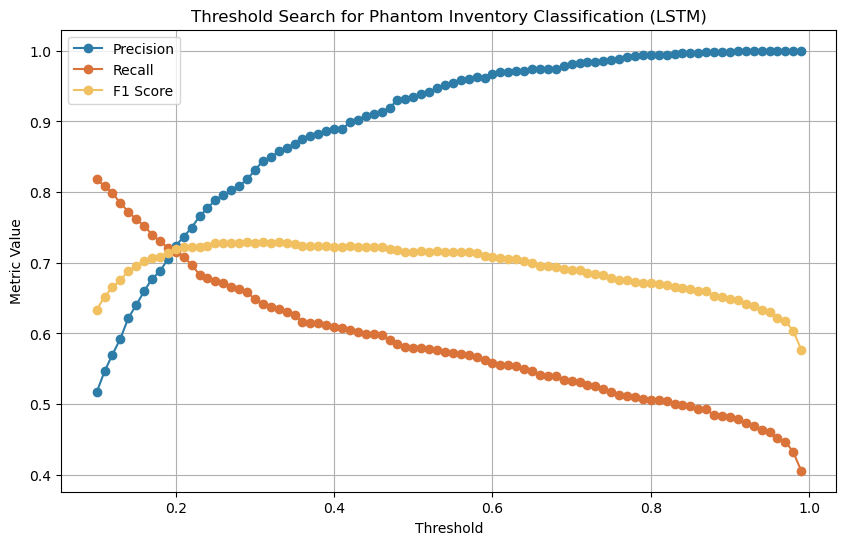

In [ ]:
# Best Threshold Search for Phantom Inventory Classification (LSTM)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Get predicted probabilities for the phantom class (Class 1) from the LSTM model.
# Ensure predictions are flattened to a 1D array.
y_pred_probs = model.predict(X_test_seq).flatten()

# Define a range of thresholds to search over (from 0.1 to 0.99)
thresholds = np.arange(0.1, 1.0, 0.01)
metrics_list = []

print("Threshold Search Results for LSTM:")
print("Threshold | Precision | Recall  | F1 Score | Accuracy")
for thresh in thresholds:
    # Apply threshold to get binary predictions
    y_pred_thresh = (y_pred_probs >= thresh).astype(int)
    
    # Compute metrics
    precision = precision_score(y_test, y_pred_thresh, pos_label=1)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    
    metrics_list.append((thresh, precision, recall, f1, accuracy))
    
    print(f"{thresh:8.2f} | {precision:9.4f} | {recall:7.4f} | {f1:8.4f} | {accuracy:8.4f}")

# Convert the list of metrics to a NumPy array for easier analysis
metrics_array = np.array(metrics_list)

# Example: Choose best threshold based on the minimal difference between precision and recall.
best_idx_diff = None
best_diff_score = float('inf')
for i, row in enumerate(metrics_list):
    thresh, prec, rec, f1, acc = row
    diff = abs(prec - rec)
    if diff < best_diff_score:
        best_diff_score = diff
        best_idx_diff = i

best_threshold_diff = metrics_list[best_idx_diff][0]
best_precision_diff = metrics_list[best_idx_diff][1]
best_recall_diff = metrics_list[best_idx_diff][2]
best_f1_diff = metrics_list[best_idx_diff][3]
best_accuracy_diff = metrics_list[best_idx_diff][4]

print("\nBest threshold based on minimal difference between Precision and Recall:")
print(f"Threshold: {best_threshold_diff:.2f}, Precision: {best_precision_diff:.4f}, "
      f"Recall: {best_recall_diff:.4f}, F1: {best_f1_diff:.4f}, Accuracy: {best_accuracy_diff:.4f}")

# Optionally, plot Precision, Recall, and F1 Score as a function of threshold
plt.figure(figsize=(10, 6))
plt.plot(metrics_array[:, 0], metrics_array[:, 1], label="Precision", marker='o', color="#2e7ca8")
plt.plot(metrics_array[:, 0], metrics_array[:, 2], label="Recall", marker='o', color="#d97339")
plt.plot(metrics_array[:, 0], metrics_array[:, 3], label="F1 Score", marker='o', color="#f1c061")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Search for Phantom Inventory Classification (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/2431826325.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)
/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/2431826325.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Confusion Matrix:
[[26654   218]
 [  583  1988]] 

Precision for phantom class (Class 1): 0.9012
Recall for phantom class (Class 1):    0.7732
F1 Score:                              0.8323
Accuracy:                              0.9728


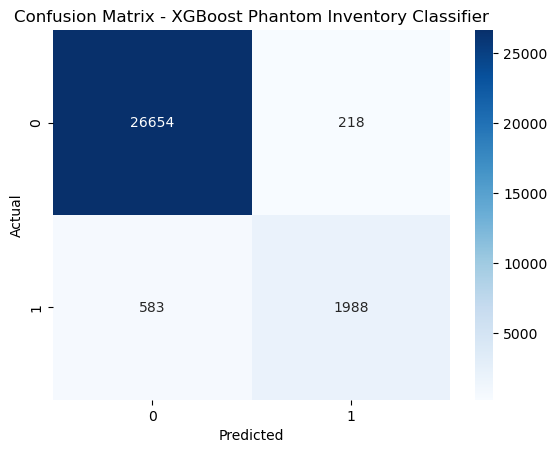

In [ ]:
# 3.XX Clustering and Classification Modeling (w/ Features Engineering) *** using XGBoost ***
# ======================

# Optional approach for moderate missing columns in "avg_sales_50to8" features directly but loss some info:
# merged["avg_sales_50to8"].fillna(0, inplace=True)
# merged["avg_sales_last7"].fillna(0, inplace=True)

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Impute the missing values with median or 0
impute_val = merged['avg_sales_50to8'].median()  # or 0
merged['avg_sales_50to8_imputed'] = merged['avg_sales_50to8'].fillna(impute_val)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# Impute missing 'avg_sales_last7' values with the median (or another strategy)
impute_val_last7 = merged['avg_sales_last7'].median()
merged['avg_sales_last7_imputed'] = merged['avg_sales_last7'].fillna(impute_val_last7)

# So, we include 'avg_sales_last7_imputed' and 'avg_sales_last7_missing' 
# in our model’s feature list instead of the raw 'avg_sales_last7'.

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 3. SKU-level median fill for any remaining missing values
sku_median_boh = merged.groupby("itemsku")["CurrentBOH"].transform(lambda x: x.fillna(x.median()))
merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)

# 4. If still missing, fill with overall median
merged["CurrentBOH"].fillna(merged["CurrentBOH"].median(), inplace=True)
# Now include "CurrentBOH_missing" as a feature in the model.

# # Option 1: Impute missing values with 0, assuming missing implies no backroom inventory.
# merged["IMSQuantity_imputed"] = features["IMSQuantity"].fillna(0)

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 5. Stock Turnover Ratio:
#    Rolling 7-day sum of ShippedQuantity divided by DailyBOH.
merged["rolling_shipped_7d"] = merged.groupby("itemsku")["ShippedQuantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).sum())
merged["stock_turnover_ratio_7d"] = merged["rolling_shipped_7d"] / (merged["DailyBOH"] + 1)

# 6. Days Since Last Sale Flag:
#    Flag if DaysSinceLastSale exceeds the median for that SKU.
if "DaysSinceLastSale" in merged.columns:
    median_days = merged.groupby("itemsku")["DaysSinceLastSale"].transform("median")
    merged["days_since_last_sale_flag"] = (merged["DaysSinceLastSale"] > median_days).astype(int)
else:
    merged["days_since_last_sale_flag"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
                   'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
                   'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

# Assuming model_data, feature_columns, and target_column are defined as in your feature engineering:
# model_data is a DataFrame that contains all the features and target.
# feature_columns is a list of column names to be used for modeling.
# target_column is the name of the column containing the binary target (phantom_flag).

# --- Convert Categorical Features to Numeric ---
for col in feature_columns:
    if model_data[col].dtype == 'object':
        model_data[col] = model_data[col].astype('category').cat.codes

# --- Prepare Data for Modeling ---
X = model_data[feature_columns]
y = model_data[target_column]

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build and Train the XGBoost Model ---
# Use use_label_encoder=False and specify an evaluation metric to avoid warnings.
xgb_model = XGBClassifier(use_label_encoder=False, 
                          eval_metric='logloss', 
                          random_state=42,
                          n_estimators=300,
                          max_depth=7,
                          learning_rate=0.2,
                          subsample=1.0,
                          colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

# --- Predict and Evaluate ---

# Get probability predictions for class 1 (phantom inventory)
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Use a custom threshold (set to 0.5 here, but feel free to adjust)
threshold = 0.53
y_pred = (y_pred_probs >= threshold).astype(int)

# Compute evaluation metrics
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print("Confusion Matrix:")
print(cm, "\n")
print("Precision for phantom class (Class 1): {:.4f}".format(precision))
print("Recall for phantom class (Class 1):    {:.4f}".format(recall))
print("F1 Score:                              {:.4f}".format(f1))
print("Accuracy:                              {:.4f}".format(accuracy))

# --- Plot the Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost Phantom Inventory Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/2776678151.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)
/var/folders/rc/km87dnjn7wvcyywzwry25sdh0000gn/T/ipykernel_23755/2776678151.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Confusion Matrix:
[[16407    96]
 [ 1050   964]] 

Precision for phantom class (Class 1): 0.9094
Recall for phantom class (Class 1):    0.4786
F1 Score:                              0.6272
Accuracy:                              0.9381


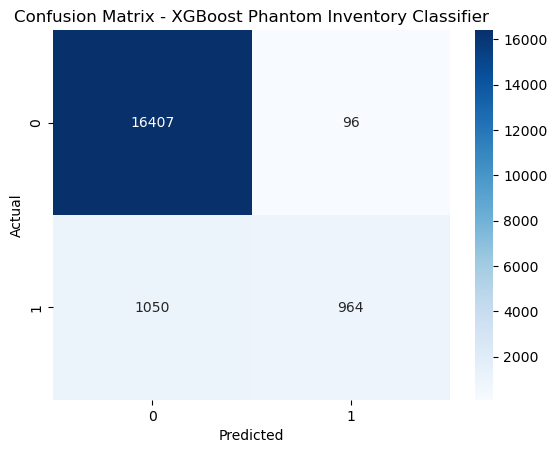

In [ ]:
# 3.XX Clustering and Classification Modeling (w/ Features Engineering) *** using XGBoost Date Seq, BAD ***
# ======================

# Optional approach for moderate missing columns in "avg_sales_50to8" features directly but loss some info:
# merged["avg_sales_50to8"].fillna(0, inplace=True)
# merged["avg_sales_last7"].fillna(0, inplace=True)

# Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# Impute the missing values with median or 0
impute_val = merged['avg_sales_50to8'].median()  # or 0
merged['avg_sales_50to8_imputed'] = merged['avg_sales_50to8'].fillna(impute_val)

# Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# Impute missing 'avg_sales_last7' values with the median (or another strategy)
impute_val_last7 = merged['avg_sales_last7'].median()
merged['avg_sales_last7_imputed'] = merged['avg_sales_last7'].fillna(impute_val_last7)

# So, we include 'avg_sales_last7_imputed' and 'avg_sales_last7_missing' 
# in our model’s feature list instead of the raw 'avg_sales_last7'.

# 1. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 2. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 3. SKU-level median fill for any remaining missing values
sku_median_boh = merged.groupby("itemsku")["CurrentBOH"].transform(lambda x: x.fillna(x.median()))
merged["CurrentBOH"].fillna(sku_median_boh, inplace=True)

# 4. If still missing, fill with overall median
merged["CurrentBOH"].fillna(merged["CurrentBOH"].median(), inplace=True)
# Now include "CurrentBOH_missing" as a feature in the model.

# # Option 1: Impute missing values with 0, assuming missing implies no backroom inventory.
# merged["IMSQuantity_imputed"] = features["IMSQuantity"].fillna(0)

# Option 2: Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# Perform clustering on selected inventory and sales features to find patterns.
# These clusters can then be used as additional features in the classification model.
cluster_features = merged[['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'ShippedQuantity']].fillna(0)

# We choose 3 clusters for illustration. Adjust n_clusters based on the exploratory analysis.
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(cluster_features)

# Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

###################################
# More Features Added (after v06.9) Additional Feature Engineering
###################################

# 2. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 3. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 7. Inventory Discrepancy: Difference between CurrentBOH and DailyBOH.
if "CurrentBOH" in merged.columns and "DailyBOH" in merged.columns:
    merged["inventory_discrepancy"] = merged["CurrentBOH"] - merged["DailyBOH"]
else:
    merged["inventory_discrepancy"] = np.nan

# 5. Stock Turnover Ratio:
#    Rolling 7-day sum of ShippedQuantity divided by DailyBOH.
merged["rolling_shipped_7d"] = merged.groupby("itemsku")["ShippedQuantity"].transform(
    lambda x: x.rolling(window=7, min_periods=1).sum())
merged["stock_turnover_ratio_7d"] = merged["rolling_shipped_7d"] / (merged["DailyBOH"] + 1)

# 6. Days Since Last Sale Flag:
#    Flag if DaysSinceLastSale exceeds the median for that SKU.
if "DaysSinceLastSale" in merged.columns:
    median_days = merged.groupby("itemsku")["DaysSinceLastSale"].transform("median")
    merged["days_since_last_sale_flag"] = (merged["DaysSinceLastSale"] > median_days).astype(int)
else:
    merged["days_since_last_sale_flag"] = np.nan

# 7. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 1. IMS to BOH Discrepancy
if "IMSQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["ims_boh_discrepancy"] = merged["IMSQuantity"] - merged["DailyBOH"]
else:
    merged["ims_boh_discrepancy"] = np.nan

# Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 3. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# 5. Zone-Based Inventory Discrepancy
if 'Zone' in merged.columns and 'DailyBOH' in merged.columns:
    merged['zone_inventory_discrepancy'] = merged['DailyBOH'] - merged.groupby('Zone')['DailyBOH'].transform('mean')
else:
    merged['zone_inventory_discrepancy'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cluster label. 
# Ensure your date column is datetime type
model_data['daydate'] = pd.to_datetime(model_data['daydate'])

# Define the split boundaries
train_end_date = '2024-11-19'
val_end_date   = '2024-11-23'
test_end_date  = '2024-11-27'

# Split the dataset sequentially
train_data = model_data[(model_data['daydate'] >= '2024-11-01') & (model_data['daydate'] <= train_end_date)]
val_data   = model_data[(model_data['daydate'] > train_end_date) & (model_data['daydate'] <= val_end_date)]
test_data  = model_data[(model_data['daydate'] > val_end_date) & (model_data['daydate'] <= test_end_date)]

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'cluster',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing', 'avg_sales_50to8_imputed',
                   'avg_sales_last7_missing', 'avg_sales_last7_imputed', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio', 'inventory_discrepancy', 'stock_turnover_ratio_7d',
                   'days_since_last_sale_flag', 'is_weekend', 'ims_boh_discrepancy', 'out_of_stock_duration', 'zone_inventory_discrepancy']
target_column = 'phantom_flag'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

# Assuming model_data, feature_columns, and target_column are defined as in your feature engineering:
# model_data is a DataFrame that contains all the features and target.
# feature_columns is a list of column names to be used for modeling.
# target_column is the name of the column containing the binary target (phantom_flag).

# --- Convert Categorical Features to Numeric ---
for col in feature_columns:
    if model_data[col].dtype == 'object':
        model_data[col] = model_data[col].astype('category').cat.codes

# --- Prepare Data for Modeling ---
X = model_data[feature_columns]
y = model_data[target_column]

# Split the data (80% train, 20% test)
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_val = val_data[feature_columns]
y_val = val_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# --- Build and Train the XGBoost Model ---
# Use use_label_encoder=False and specify an evaluation metric to avoid warnings.
xgb_model = XGBClassifier(use_label_encoder=False, 
                          eval_metric='logloss', 
                          random_state=42,
                          n_estimators=300,
                          max_depth=7,
                          learning_rate=0.2,
                          subsample=1.0,
                          colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

# --- Predict and Evaluate ---

# Get probability predictions for class 1 (phantom inventory)
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Use a custom threshold (set to 0.5 here, but feel free to adjust)
threshold = 0.53
y_pred = (y_pred_probs >= threshold).astype(int)

# Compute evaluation metrics
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print("Confusion Matrix:")
print(cm, "\n")
print("Precision for phantom class (Class 1): {:.4f}".format(precision))
print("Recall for phantom class (Class 1):    {:.4f}".format(recall))
print("F1 Score:                              {:.4f}".format(f1))
print("Accuracy:                              {:.4f}".format(accuracy))

# --- Plot the Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost Phantom Inventory Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
# ###### Best Parameter Search for XGBoost

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

# --- Prepare Data for Modeling ---
# Assuming model_data, feature_columns, and target_column are defined as in your feature engineering.
# Convert any categorical columns in feature_columns to numeric, if not already done.
for col in feature_columns:
    if model_data[col].dtype == 'object':
        model_data[col] = model_data[col].astype('category').cat.codes

X = model_data[feature_columns]
y = model_data[target_column]

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define Parameter Grid for XGBoost ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an XGBClassifier instance.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='accuracy',  # You can change this to another metric if needed.
                           cv=3, 
                           verbose=1)

# Fit the grid search to the training data.
grid_result = grid_search.fit(X_train, y_train)

# Print best score and parameters.
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:06:00] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:06:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:06:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning

Best: 0.971190 using {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


Threshold Search Results for XGBoost:
Threshold | Precision | Recall  | F1 Score | Accuracy
    0.10 |    0.6515 |  0.9518 |   0.7735 |   0.9513
    0.11 |    0.6653 |  0.9455 |   0.7810 |   0.9537
    0.12 |    0.6716 |  0.9432 |   0.7845 |   0.9548
    0.13 |    0.6805 |  0.9401 |   0.7895 |   0.9562
    0.14 |    0.6942 |  0.9323 |   0.7958 |   0.9582
    0.15 |    0.6994 |  0.9296 |   0.7983 |   0.9590
    0.16 |    0.7061 |  0.9249 |   0.8008 |   0.9598
    0.17 |    0.7173 |  0.9187 |   0.8056 |   0.9613
    0.18 |    0.7244 |  0.9172 |   0.8095 |   0.9623
    0.19 |    0.7327 |  0.9086 |   0.8113 |   0.9631
    0.20 |    0.7408 |  0.9070 |   0.8155 |   0.9642
    0.21 |    0.7455 |  0.9047 |   0.8174 |   0.9647
    0.22 |    0.7538 |  0.9004 |   0.8206 |   0.9656
    0.23 |    0.7599 |  0.8985 |   0.8234 |   0.9663
    0.24 |    0.7640 |  0.8938 |   0.8238 |   0.9666
    0.25 |    0.7698 |  0.8895 |   0.8253 |   0.9671
    0.26 |    0.7793 |  0.8860 |   0.8293 |   0.9681
    0.2

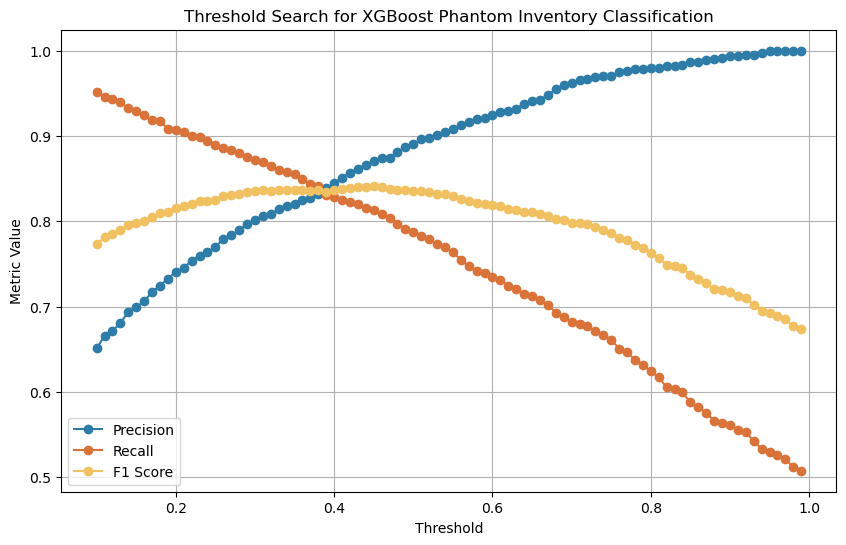

In [20]:
# ###### Best Threshold Search for XGBoost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Predict probabilities for the phantom class (class 1) on the test set.
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds to search over (0.1 to 0.99)
thresholds = np.arange(0.1, 1.0, 0.01)
metrics_list = []

print("Threshold Search Results for XGBoost:")
print("Threshold | Precision | Recall  | F1 Score | Accuracy")
for thresh in thresholds:
    # Generate binary predictions based on the current threshold.
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    # Compute evaluation metrics.
    precision = precision_score(y_test, y_pred_thresh, pos_label=1)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    
    metrics_list.append((thresh, precision, recall, f1, accuracy))
    
    print(f"{thresh:8.2f} | {precision:9.4f} | {recall:7.4f} | {f1:8.4f} | {accuracy:8.4f}")

# Convert metrics list to an array for easier plotting.
metrics_array = np.array(metrics_list)

# Example: Select the best threshold based on the minimal difference between precision and recall.
best_idx_diff = None
best_diff_score = float('inf')
for i, row in enumerate(metrics_list):
    thresh, prec, rec, f1, acc = row
    diff = abs(prec - rec)
    if diff < best_diff_score:
        best_diff_score = diff
        best_idx_diff = i

best_threshold_diff = metrics_list[best_idx_diff][0]
best_precision_diff = metrics_list[best_idx_diff][1]
best_recall_diff = metrics_list[best_idx_diff][2]
best_f1_diff = metrics_list[best_idx_diff][3]
best_accuracy_diff = metrics_list[best_idx_diff][4]

print("\nBest threshold based on minimal difference between Precision and Recall:")
print(f"Threshold: {best_threshold_diff:.2f}, Precision: {best_precision_diff:.4f}, "
      f"Recall: {best_recall_diff:.4f}, F1: {best_f1_diff:.4f}, Accuracy: {best_accuracy_diff:.4f}")

# Optionally, plot the metric values as a function of threshold.
plt.figure(figsize=(10, 6))
plt.plot(metrics_array[:, 0], metrics_array[:, 1], label="Precision", marker='o', color="#2e7ca8")
plt.plot(metrics_array[:, 0], metrics_array[:, 2], label="Recall", marker='o', color="#d97339")
plt.plot(metrics_array[:, 0], metrics_array[:, 3], label="F1 Score", marker='o', color="#f1c061")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Search for XGBoost Phantom Inventory Classification")
plt.legend()
plt.grid(True)
plt.show()

Training AUC: 0.9948
Validation AUC: 0.9856


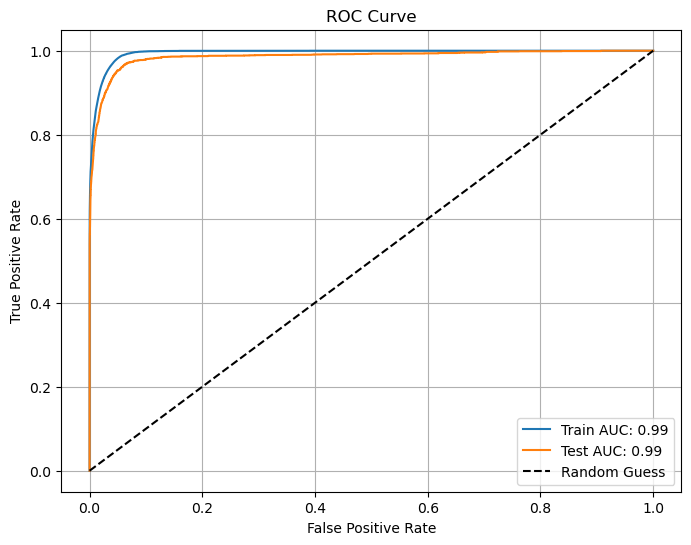

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:35] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:36] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning

Cross-validated AUC scores: [0.91347271 0.87000506 0.89831204 0.90408207 0.88503414]
Mean cross-validated AUC: 0.8942


In [ ]:
# XGBoost ROC AUC

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

# Assume xgb_model is your trained XGBoost model, and X_train, X_test, y_train, y_test are already defined.

# --- Evaluate Training vs. Validation AUC ---

# Predict probabilities on the training set
y_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Predict probabilities on the test (validation) set
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Training AUC: {:.4f}".format(train_auc))
print("Validation AUC: {:.4f}".format(test_auc))

# --- Plot ROC Curves for Training and Test Sets ---

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC: {train_auc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC: {test_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Cross-Validated AUC Scores ---

# Perform 5-fold cross-validation with ROC AUC as the scoring metric.
cv_auc_scores = cross_val_score(xgb_model, X, y, cv=5, scoring="roc_auc")
print("Cross-validated AUC scores:", cv_auc_scores)
print("Mean cross-validated AUC: {:.4f}".format(cv_auc_scores.mean()))

Threshold Search Results:
Threshold | Precision | Recall  | F1 Score | Accuracy
    0.10 |    0.5779 |  0.9708 |   0.7245 |   0.9355
    0.11 |    0.5935 |  0.9701 |   0.7365 |   0.9394
    0.12 |    0.5997 |  0.9701 |   0.7412 |   0.9408
    0.13 |    0.6073 |  0.9689 |   0.7466 |   0.9426
    0.14 |    0.6141 |  0.9673 |   0.7512 |   0.9441
    0.15 |    0.6206 |  0.9646 |   0.7553 |   0.9454
    0.16 |    0.6284 |  0.9623 |   0.7603 |   0.9470
    0.17 |    0.6401 |  0.9588 |   0.7677 |   0.9493
    0.18 |    0.6471 |  0.9557 |   0.7717 |   0.9506
    0.19 |    0.6558 |  0.9522 |   0.7766 |   0.9522
    0.20 |    0.6635 |  0.9487 |   0.7809 |   0.9535
    0.21 |    0.6674 |  0.9475 |   0.7832 |   0.9542
    0.22 |    0.6773 |  0.9455 |   0.7893 |   0.9559
    0.23 |    0.6807 |  0.9436 |   0.7909 |   0.9564
    0.24 |    0.6864 |  0.9409 |   0.7938 |   0.9573
    0.25 |    0.6937 |  0.9354 |   0.7966 |   0.9583
    0.26 |    0.6980 |  0.9331 |   0.7986 |   0.9589
    0.27 |    0.703

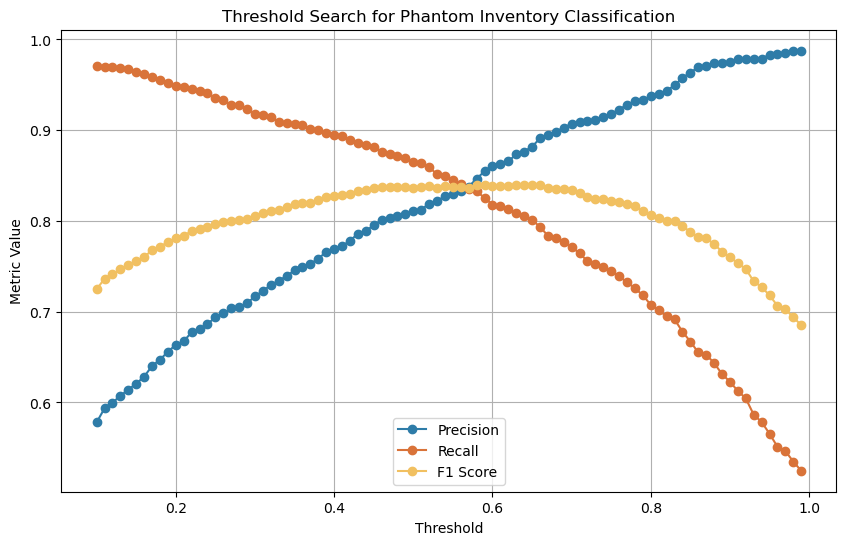

In [ ]:
# Best Threshold Search for Phantom Inventory Classification (RF)
# ======================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming X_test, y_test, and the trained rf model are available from your previous steps.
# Get predicted probabilities for the phantom class (Class 1)
y_proba = rf.predict_proba(X_test)[:, 1]

# Define a range of thresholds to search over (from 0.1 to 0.99)
thresholds = np.arange(0.1, 1.0, 0.01)
metrics_list = []

print("Threshold Search Results:")
print("Threshold | Precision | Recall  | F1 Score | Accuracy")
for thresh in thresholds:
    # Apply threshold to get binary predictions
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    # Compute metrics
    cm = confusion_matrix(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, pos_label=1)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    
    metrics_list.append((thresh, precision, recall, f1, accuracy))
    
    print(f"{thresh:8.2f} | {precision:9.4f} | {recall:7.4f} | {f1:8.4f} | {accuracy:8.4f}")

# Convert the list of metrics to a NumPy array for easier analysis
metrics_array = np.array(metrics_list)

# Example: Choose best threshold based on highest F1 Score (balanced approach)
best_idx_diff = None
best_diff_score = float('inf')

for i, row in enumerate(metrics_list):
    thresh, prec, rec, f1, acc = row
    diff = abs(prec - rec)
    if diff < best_diff_score:
        best_diff_score = diff
        best_idx_diff = i

best_threshold_diff = metrics_list[best_idx_diff][0]
best_precision_diff = metrics_list[best_idx_diff][1]
best_recall_diff = metrics_list[best_idx_diff][2]
best_f1_diff = metrics_list[best_idx_diff][3]
best_accuracy_diff = metrics_list[best_idx_diff][4]

print("\nBest threshold based on minimal difference between Precision and Recall:")
print(f"Threshold: {best_threshold_diff:.2f}, Precision: {best_precision_diff:.4f}, "
      f"Recall: {best_recall_diff:.4f}, F1: {best_f1_diff:.4f}, Accuracy: {best_accuracy_diff:.4f}")

# Optionally, plot Precision, Recall, and F1 Score as a function of threshold
plt.figure(figsize=(10, 6))
plt.plot(metrics_array[:, 0], metrics_array[:, 1], label="Precision", marker='o', color="#2e7ca8")
plt.plot(metrics_array[:, 0], metrics_array[:, 2], label="Recall", marker='o', color="#d97339")
plt.plot(metrics_array[:, 0], metrics_array[:, 3], label="F1 Score", marker='o', color="#f1c061")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Search for Phantom Inventory Classification")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ****** LSTM w/o TimeGAN test (Be aware NOT in RMSE) ******
# 4. Time Series Forecasting with LSTM for Run-Out Prediction (for all SKUs) [*** This version APPLIES log on "DailyBOH" and is OPTIMIZED ***]
# ======================

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def forecast_run_out_for_sku(item_data, window_size=7, forecast_horizon=7,
                             cap_percentile=0.99,
                             use_robust_scaler=False,
                             use_stacked_lstm=False,
                             additional_feature="trxn_total_qty"):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate' and 'DailyBOH'.
                               If additional_feature is provided, that column must exist.
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler instead of MinMaxScaler.
        use_stacked_lstm (bool): If True, use a stacked LSTM architecture.
        additional_feature (str or None): If provided, use this column as an extra feature.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions (list): Forecasted DailyBOH values (in original scale).
        mse_original (float): MSE in the original domain for LSTM forecast.
        mse_baseline (float): MSE in the original domain for a naive baseline forecast.
    """

    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # If additional_feature is provided, merge it (assume same daydate index)
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None  # Not enough data

    # 2. Cap outliers on DailyBOH
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform to the capped DailyBOH
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y
    # If additional_feature is used, include it as a second column per time step.
    if additional_feature is not None:
        ts_values = ts_data[['DailyBOH_trans', additional_feature]].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler: use RobustScaler if specified, otherwise MinMaxScaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    # For univariate, flatten to 1D; for multivariate, keep the shape.
    # We'll assume that the first column is the DailyBOH_trans.
    if ts_values_scaled.shape[1] > 1:
        # We only forecast DailyBOH, so we take the first column as target.
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # Create sliding windows for target. For multivariate, create X windows with all features.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    # Reshape X_ts for LSTM: if univariate, add third dimension.
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 6. Build the LSTM model
    if use_stacked_lstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
            tf.keras.layers.LSTM(30, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.LSTM(50, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 7. Train the model
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 8. Evaluate model on training windows (print loss)
    train_loss = model.evaluate(X_ts, y_ts, verbose=0)
    print(f"LSTM Training Loss (MSE) for this SKU: {train_loss:.4f}")
    
    # 9. Forecast future inventory for the next forecast_horizon days
    predictions_scaled = []
    # Use the last available window from the scaled data (only the features corresponding to DailyBOH_trans)
    if ts_values_scaled.shape[1] > 1:
        # Extract the window for DailyBOH_trans (first column) from the last window of the multivariate input
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        # If multivariate, current_window shape is (window_size, num_features)
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        # Update window: remove first row, append new prediction in the first column; for additional features, we replicate the last value.
        if ts_values_scaled.shape[1] > 1:
            # For DailyBOH_trans, update with pred_value; for other features, keep last row values.
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 10. Inverse the scaling and transforms to get predictions in original scale.
    # First, create an array of predictions with the same number of features as used for scaling.
    if ts_values_scaled.shape[1] > 1:
        # Only update the first column (DailyBOH_trans) with predictions; keep the others as the last row's values.
        inv_array = []
        for pred in predictions_scaled:
            # Create a row with pred for DailyBOH_trans and use last row's other feature values.
            row = current_window[-1, :].copy()  # Use last row as a template
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    # Invert the log1p transform: original value = exp(pred) - 1
    predictions_original = np.expm1(predictions_transformed)
    
    # 11. Compute Baseline Forecast (naive forecast: repeat last observed value)
    # Create a baseline array with the same number of features as ts_values_scaled.
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]  # This is a 1D array of shape (n_features,)
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))  # Shape becomes (forecast_horizon, n_features)
    # Inverse transform the baseline; we only care about the first column (DailyBOH_trans)
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)

    # 12. Compute MSE in the original domain (for LSTM forecast vs. baseline)
    # For evaluation, assume actual values are the last 'forecast_horizon' values of the capped DailyBOH.
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    # print(f"MSE in the original domain (LSTM): {mse_original:.4f}")   # Further evaluation needed (more data).
    # print(f"MSE in the original domain (Baseline): {mse_baseline:.4f}")   # Further evaluation needed (more data).
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, mse_original, mse_baseline

# ======================
# Usage for All SKUs
# ======================
unique_skus = features['itemsku'].dropna().unique()
results = []
for sku in unique_skus:
    # Extract and sort the time series data for the SKU
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    # Unpack all four returned values from the forecasting function.
    run_out_day, predictions, mse_original, mse_baseline = forecast_run_out_for_sku(
        item_data, 
        window_size=7, 
        forecast_horizon=7, 
        cap_percentile=0.99  # Adjust as needed
    )
    
    if predictions is None:
        print(f"SKU {sku}: Not enough data for forecasting (requires at least {7 + 1} data points).")
    elif run_out_day is not None:
        results.append({
            'itemsku': sku, 
            'run_out_day': run_out_day.date(), 
            'predictions': predictions,
            'mse_lstm': mse_original,
            'mse_baseline': mse_baseline
        })
    else:
        print(f"SKU {sku}: Not predicted to run out in the next 7 days.")

results_df = pd.DataFrame(results)
print("\nForecasted run-out dates for SKUs:")
print(results_df)

LSTM Training Loss (MSE) for this SKU: 0.0452
SKU 5000000928: Not predicted to run out in the next 7 days.
LSTM Training Loss (MSE) for this SKU: 0.0977
SKU 7590033333: Not predicted to run out in the next 7 days.
LSTM Training Loss (MSE) for this SKU: 0.1000
SKU 68954408146: Not predicted to run out in the next 7 days.
LSTM Training Loss (MSE) for this SKU: 0.0697
SKU 68954408166: Not predicted to run out in the next 7 days.
LSTM Training Loss (MSE) for this SKU: 0.0558
SKU 89470001043: Not predicted to run out in the next 7 days.
LSTM Training Loss (MSE) for this SKU: 0.1049
SKU 2100003045: Not predicted to run out in the next 7 days.


KeyboardInterrupt: 

In [ ]:
# ****** BiLSTM w/o TimeGAN test (Be aware NOT in RMSE) ****** 
# 4. Time Series Forecasting with BiLSTM for Run-Out Prediction (Loop over all SKUs)
# ======================

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Model 1: BiLSTM with Phantom Inventory Classification Indicator for Run-Out Prediction
# ======================

def forecast_run_out_for_sku_model1(item_data, window_size=7, forecast_horizon=7,
                                    cap_percentile=0.99,
                                    use_robust_scaler=False,
                                    use_stacked_bilstm=False,
                                    additional_feature="phantom_flag"):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using a Bidirectional LSTM (BiLSTM)
    and incorporating an additional feature from phantom inventory classification.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate', 'DailyBOH', and the additional feature (e.g., 'phantom_flag').
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler instead of MinMaxScaler.
        use_stacked_bilstm (bool): If True, use a stacked BiLSTM architecture; otherwise, use a single BiLSTM layer.
        additional_feature (str or None): The name of the column to use as an extra feature.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions (list): Forecasted DailyBOH values (in original scale).
        mse_original (float): MSE in the original domain for BiLSTM forecast.
        mse_baseline (float): MSE in the original domain for a naive baseline forecast.
    """
    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # Merge the additional feature (e.g., phantom_flag), if provided and exists.
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    # If there is not enough data for the sliding window, return None.
    if len(ts_data) <= window_size:
        return None, None, None, None

    # 2. Cap outliers on DailyBOH
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform to the capped DailyBOH
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y.
    # If additional_feature is used, include it as an extra column.
    if additional_feature is not None and additional_feature in ts_data.columns:
        # Our feature set includes the transformed DailyBOH and the phantom flag.
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler: use RobustScaler if specified, otherwise MinMaxScaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    # We forecast only DailyBOH; assume it is in the first column.
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows from the scaled data.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    # Reshape X_ts for LSTM if univariate.
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Build the BiLSTM model (Model 1)
    if use_stacked_bilstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 8. Train the model with early stopping.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 9. Evaluate the model on training windows.
    train_loss = model.evaluate(X_ts, y_ts, verbose=0)
    print(f"BiLSTM Training Loss (MSE) for this SKU: {train_loss:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform the predictions back to the original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Compute a baseline (naive forecast: repeat last observed value) and its MSE.
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    # 13. Determine the first day when predicted inventory is <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, mse_original, mse_baseline

# ======================
# Usage for All SKUs – Model 1 Implementation
# ======================
# Here, we assume that 'features' is your merged DataFrame that includes columns
# such as 'daydate', 'DailyBOH', and 'phantom_flag' (computed from your classification rules).

# Define forecast_horizon for clarity
forecast_horizon = 7
window_size= 7

unique_skus = features['itemsku'].dropna().unique()
results_model1 = []
for sku in unique_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    # Use the phantom_flag as an additional feature for forecasting.
    run_out_day, predictions, mse_bilstm, mse_baseline = forecast_run_out_for_sku_model1(
        item_data,
        cap_percentile=0.99,
        use_robust_scaler=False,
        use_stacked_bilstm=False,   # Set to True if you want to test a stacked BiLSTM
        additional_feature="phantom_flag"
    )
    
    if predictions is None:
        print(f"SKU {sku}: Not enough data for forecasting (requires at least {window_size + 1} data points).")
    elif run_out_day is not None:
        results_model1.append({
            'itemsku': sku, 
            'run_out_day': run_out_day.date(), 
            'predictions': predictions,
            'mse_bilstm': mse_bilstm,
            'mse_baseline': mse_baseline
        })
    else:
        print(f"SKU {sku}: Not predicted to run out in the next {forecast_horizon} days.")

results_df_model1 = pd.DataFrame(results_model1)
print("\nForecasted run-out dates for SKUs (Model 1 - BiLSTM with Phantom Classification):")
print(results_df_model1)

BiLSTM Training Loss (MSE) for this SKU: 0.0595
SKU 5000000928: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0990
SKU 7590033333: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0922
SKU 68954408146: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0686
SKU 68954408166: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0656
SKU 89470001043: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.1033
SKU 2100003045: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0487
SKU 4127100492: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (MSE) for this SKU: 0.0513
SKU 4900055124: Not predicted to run out in the next 7 days.


KeyboardInterrupt: 

In [ ]:
# ****** BiLSTM w/ TimeGAN (Loop Over SKUs) test, NO Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = models.Sequential([
            layers.Input(shape=(self.seq_len, self.feature_dim)),
            layers.LSTM(self.hidden_dim, return_sequences=True),
            layers.LSTM(self.hidden_dim, return_sequences=True)
        ])

        # Recovery network: now expects input of shape (seq_len, hidden_dim)
        self.recovery = models.Sequential([
            layers.Input(shape=(self.seq_len, self.hidden_dim)),
            layers.LSTM(self.hidden_dim, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.feature_dim))
        ])

        # Generator: generates latent representations from random noise.
        self.generator = models.Sequential([
            layers.Input(shape=(self.seq_len, self.hidden_dim)),
            layers.LSTM(self.hidden_dim, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.hidden_dim, activation='tanh'))
        ])

        # Supervisor: helps generate better latent representations.
        self.supervisor = models.Sequential([
            layers.Input(shape=(self.seq_len, self.hidden_dim)),
            layers.LSTM(self.hidden_dim, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.hidden_dim, activation='tanh'))
        ])

        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = models.Sequential([
            layers.Input(shape=(self.seq_len, self.hidden_dim)),
            layers.LSTM(self.hidden_dim, return_sequences=False),
            layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = models.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        # Pretrain the autoencoder (embedder + recovery) to learn latent representations.
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        # Generate synthetic time series data.
        # Step 1: Sample random noise in latent space.
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        # Step 2: Generate latent sequences with generator and supervisor.
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        # Step 3: Recover synthetic time series from latent representations.
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ----- Model 1: BiLSTM Forecasting with Phantom Flag and TimeGAN Data Augmentation -----
def forecast_run_out_for_sku_model1(item_data, window_size=7, forecast_horizon=7,
                                    cap_percentile=0.99,
                                    use_robust_scaler=False,
                                    use_stacked_bilstm=False,
                                    additional_feature="phantom_flag",
                                    use_timegan=False,
                                    num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using a BiLSTM and
    incorporating an additional feature (phantom_flag). Optionally, synthetic data is generated 
    using TimeGAN and used to augment the training set.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate', 'DailyBOH', and additional feature (e.g., 'phantom_flag').
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler instead of MinMaxScaler.
        use_stacked_bilstm (bool): If True, use a stacked BiLSTM architecture.
        additional_feature (str or None): Name of the extra feature column.
        use_timegan (bool): If True, use TimeGAN to generate synthetic data to augment training.
        num_synthetic (int): Number of synthetic samples to generate if use_timegan is True.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions (list): Forecasted DailyBOH values (in original scale).
        mse_original (float): MSE in the original domain for BiLSTM forecast.
        mse_baseline (float): MSE in the original domain for a naive baseline forecast.
    """
    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # If additional_feature is provided, merge it (assume same daydate order)
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None  # Not enough data

    # 2. Cap outliers on DailyBOH
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform to the capped DailyBOH
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y
    # Use additional feature if available; otherwise, use only DailyBOH_trans.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler: use RobustScaler if specified, otherwise MinMaxScaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    # For univariate, flatten; for multivariate, keep shape.
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows for target.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Optional: Augment with TimeGAN synthetic data.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the BiLSTM model.
    if use_stacked_bilstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train the model with early stopping.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    train_loss = model.evaluate(X_ts, y_ts, verbose=0)
    # Convert MSE to RMSE
    rmse = np.sqrt(train_loss)
    print(f"BiLSTM Training Loss (RMSE) for this SKU: {rmse:.4f}")
    # print(f"BiLSTM Training Loss (MSE) for this SKU: {train_loss:.4f}")   # for MSE
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Compute a baseline forecast (naive forecast: repeat last observed value) and its MSE.
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, mse_original, mse_baseline

# ======================
# Usage for All SKUs – Model 1 with TimeGAN Data Augmentation
# ======================
unique_skus = features['itemsku'].dropna().unique()
results_model1 = []
forecast_horizon = 7  # define forecast horizon
window_size = 7

for sku in unique_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    run_out_day, predictions, mse_bilstm, mse_baseline = forecast_run_out_for_sku_model1(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        use_stacked_bilstm=False,   # Set True to try stacked BiLSTM.
        additional_feature="phantom_flag",
        use_timegan=True,           # Enable TimeGAN-based data augmentation.
        num_synthetic=100
    )
    
    if predictions is None:
        print(f"SKU {sku}: Not enough data for forecasting (requires at least {window_size + 1} data points).")
    elif run_out_day is not None:
        results_model1.append({
            'itemsku': sku, 
            'run_out_day': run_out_day.date(), 
            'predictions': predictions,
            'mse_bilstm': mse_bilstm,
            'mse_baseline': mse_baseline
        })
    else:
        print(f"SKU {sku}: Not predicted to run out in the next {forecast_horizon} days.")

results_df_model1 = pd.DataFrame(results_model1)
print("\nForecasted run-out dates for SKUs (Model 1 - BiLSTM with Phantom Classification & TimeGAN Augmentation):")
print(results_df_model1)

BiLSTM Training Loss (RMSE) for this SKU: 0.1095
SKU 5000000928: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.1151
SKU 7590033333: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.1121
SKU 68954408146: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.1077
SKU 68954408166: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.0995
SKU 89470001043: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.1153
SKU 2100003045: Not predicted to run out in the next 7 days.
BiLSTM Training Loss (RMSE) for this SKU: 0.0841
SKU 4127100492: Not predicted to run out in the next 7 days.


KeyboardInterrupt: 

In [ ]:
#################### Pick Insightful 15 SKUs

import pandas as pd
import numpy as np

def pick_insightful_skus(features, num_skus=10):
    """
    Picks a subset of SKUs that are 'insightful' based on:
      - having enough data points,
      - having higher standard deviation of DailyBOH,
      - having moderate to high mean DailyBOH.
    
    Args:
      features: DataFrame containing at least columns: ['itemsku', 'daydate', 'DailyBOH'].
      num_skus: Number of SKUs to pick.
    
    Returns:
      A list of itemsku IDs (strings or ints) that are deemed 'insightful'.
    """
    # 1. Ensure data is sorted or aggregated by SKU & daydate if needed.
    #    For this example, we assume 'features' is already at daily granularity.
    
    # 2. Group by SKU and compute stats.
    sku_stats = features.groupby('itemsku').agg({
        'DailyBOH': ['mean', 'std', 'count']
    }).reset_index()
    sku_stats.columns = ['itemsku', 'mean_boh', 'std_boh', 'count_boh']
    
    # 3. Filter out SKUs that have too few data points, e.g., less than 30 days.
    min_data_points = 30
    sku_stats = sku_stats[sku_stats['count_boh'] >= min_data_points]
    
    # 4. Create a simple scoring function. For instance, rank SKUs by:
    #    - std_boh (std rank)
    #    - mean_boh (mean rank)
    # We combine these ranks (like sum of ranks).
    sku_stats['rank_std'] = sku_stats['std_boh'].rank(ascending=False)
    sku_stats['rank_mean'] = sku_stats['mean_boh'].rank(ascending=False)
    
    # Weighted approach: e.g. 60% emphasis on std, 40% on mean
    # This is arbitrary and can be tuned.
    sku_stats['score'] = 0.6 * sku_stats['rank_std'] + 0.4 * sku_stats['rank_mean']
    
    # 5. Sort by the combined score.
    sku_stats.sort_values('score', ascending=True, inplace=True)  # ascending=True if rank 1 is best
    # Pick top 'num_skus'.
    top_skus = sku_stats.head(num_skus)['itemsku'].tolist()
    
    return top_skus

# Usage example
top_10_skus = pick_insightful_skus(features, num_skus=15)
print("Selected 10 SKUs:", top_10_skus)

Selected 10 SKUs: [2100061263, 2100008271, 2100062679, 7396000001, 7047021989, 81829001902, 7160001655, 7171500111, 7396000002, 7396000007, 81829001908, 81829001831, 1800000735, 7047021829, 2016922235]


In [ ]:
# ****** LSTM w/o TimeGAN (On 10 SKUs) NOT Good, NO Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely, returning np.nan if either input has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

def forecast_run_out_for_sku(item_data, window_size=7, forecast_horizon=7,
                             cap_percentile=0.99,
                             use_robust_scaler=False,
                             use_stacked_lstm=False,
                             additional_feature="trxn_total_qty"):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH.
    Reports RMSE, Euclidean Distance, and Pearson Correlation for the final forecast.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate' and 'DailyBOH'.
                               If additional_feature is provided, that column must exist.
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler; otherwise, MinMaxScaler.
        use_stacked_lstm (bool): If True, use a stacked LSTM architecture.
        additional_feature (str or None): If provided, use this column as an extra feature.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions (list): Forecasted DailyBOH values (in original scale).
        rmse_lstm (float): RMSE in the original domain for the LSTM forecast.
        rmse_baseline (float): RMSE in the original domain for the naive baseline forecast.
        euclid_dist (float): Euclidean distance between actual and forecasted values.
        pearson_corr_val (float): Pearson correlation coefficient between actual and forecasted values.
    """

    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # If additional_feature is provided, merge it (assume same daydate order)
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None  # Not enough data

    # 2. Cap outliers on DailyBOH
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform to the capped DailyBOH
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y
    if additional_feature is not None and additional_feature in ts_data.columns:
        ts_values = ts_data[['DailyBOH_trans', additional_feature]].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler: use RobustScaler if specified, otherwise MinMaxScaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    # For multivariate, assume first column is DailyBOH_trans.
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows for target.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Build the LSTM model
    if use_stacked_lstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
            tf.keras.layers.LSTM(30, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.LSTM(50, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 8. Train the model with early stopping.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 9. Evaluate model on training windows (MSE -> RMSE)
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"LSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions to original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive forecast: repeat last observed value)
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    # 13. Compute evaluation metrics on the original scale.
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    # Compute Euclidean Distance and Pearson Correlation.
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 14. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    # plt.figure(figsize=(10, 5))
    # plt.plot(ts_data['DailyBOH_capped'].tail(forecast_horizon).index, actual_values, label='Actual')
    # plt.plot(ts_data['DailyBOH_capped'].tail(forecast_horizon).index, predictions_original, label='Forecast')
    # plt.legend()
    # plt.title("Actual vs. Forecasted Inventory")
    # plt.show()

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

# ======================
# Usage for a Subset of SKUs – Using the selected 10 SKUs
# ======================
selected_skus = [1800000735, 2100008271, 2100062679, 7396000001, 7047021989, 
                 4127100492, 7160001655, 7171500111, 7396000002, 7396000007]

results = []
forecast_horizon = 7
window_size = 7

for sku in selected_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    run_out_day, predictions, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = forecast_run_out_for_sku(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        use_stacked_lstm=False,
        additional_feature=None  # Change to "trxn_total_qty" if needed.
    )
    
    # Append results regardless of run_out_day value.
    results.append({
        'itemsku': sku, 
        'run_out_day': run_out_day.date() if run_out_day is not None else None, 
        'rmse_lstm': rmse_lstm,
        'rmse_baseline': rmse_baseline,
        'euclid_distance': euclid_dist,
        'pearson_corr': pearson_corr_val
    })

results_df = pd.DataFrame(results)
print("\nForecasted run-out dates and evaluation metrics for the selected SKUs:")
print(results_df)

LSTM Training Loss (RMSE) for this SKU: 0.1895
LSTM Training Loss (RMSE) for this SKU: 0.2430
LSTM Training Loss (RMSE) for this SKU: 0.2799
LSTM Training Loss (RMSE) for this SKU: 0.1702
LSTM Training Loss (RMSE) for this SKU: 0.2078
LSTM Training Loss (RMSE) for this SKU: 0.2040
LSTM Training Loss (RMSE) for this SKU: 0.2494
LSTM Training Loss (RMSE) for this SKU: 0.3184
LSTM Training Loss (RMSE) for this SKU: 0.2316
LSTM Training Loss (RMSE) for this SKU: 0.1800

Forecasted run-out dates and evaluation metrics for the selected SKUs:
      itemsku run_out_day   rmse_lstm  rmse_baseline  euclid_distance  \
0  1800000735        None  213.903993       6.202622       565.936769   
1  2100008271        None    8.284269      10.134806        21.918115   
2  2100062679        None  137.268862      13.559393       363.179271   
3  7396000001        None  319.146668      10.882489       844.382716   
4  7047021989        None    5.502651       5.318432        14.558647   
5  4127100492       

In [ ]:
# ****** BiLSTM w/o TimeGAN (On 10 SKUs) NOT Good, NO Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ======================
# Model 1: BiLSTM with Phantom Inventory Classification Indicator for Run-Out Prediction
# (BiLSTM without TimeGAN augmentation)
# ======================

def forecast_run_out_for_sku_model1(item_data, window_size=7, forecast_horizon=7,
                                    cap_percentile=0.99,
                                    use_robust_scaler=False,
                                    use_stacked_bilstm=False,
                                    additional_feature="phantom_flag"):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using a Bidirectional LSTM (BiLSTM)
    and incorporating an additional feature from phantom inventory classification.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate', 'DailyBOH', and the additional feature (e.g., 'phantom_flag').
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler; otherwise, use MinMaxScaler.
        use_stacked_bilstm (bool): If True, use a stacked BiLSTM architecture; otherwise, use a single BiLSTM layer.
        additional_feature (str or None): The name of the column to use as an extra feature.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions (list): Forecasted DailyBOH values (in original scale).
        rmse_lstm (float): RMSE in the original domain for the BiLSTM forecast.
        rmse_baseline (float): RMSE in the original domain for a naive baseline forecast.
        euclid_dist (float): Euclidean distance between actual and forecasted values.
        pearson_corr_val (float): Pearson correlation coefficient between actual and forecasted values.
    """
    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # Merge the additional feature, if provided and exists.
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None  # Not enough data

    # 2. Cap outliers on DailyBOH
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform to the capped DailyBOH
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler: use RobustScaler if specified, else MinMaxScaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    # For multivariate, assume the first column is DailyBOH_trans.
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows for target.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Build the BiLSTM model
    if use_stacked_bilstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 8. Train the model with early stopping.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 9. Evaluate the model on training windows (convert MSE to RMSE)
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"BiLSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions back to original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Compute a baseline forecast (naive: repeat last observed value) and its error.
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    # 13. Compute evaluation metrics on the original scale.
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 14. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

# ======================
# Usage for the Selected 10 SKUs
# ======================
selected_skus = [1800000735, 2100008271, 2100062679, 7396000001, 7047021989, 
                 4127100492, 7160001655, 7171500111, 7396000002, 7396000007]

results = []
forecast_horizon = 7
window_size = 7

for sku in selected_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    run_out_day, predictions, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = forecast_run_out_for_sku_model1(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        use_stacked_bilstm=False,   # Set to True if you want to try a stacked BiLSTM.
        additional_feature="phantom_flag"
    )
    
    results.append({
        'itemsku': sku, 
        'run_out_day': run_out_day.date() if run_out_day is not None else None, 
        'rmse_lstm': rmse_lstm,
        'rmse_baseline': rmse_baseline,
        'euclid_distance': euclid_dist,
        'pearson_corr': pearson_corr_val
    })

results_df_model1 = pd.DataFrame(results)
print("\nForecasted run-out dates and evaluation metrics for the selected SKUs (BiLSTM Model 1):")
print(results_df_model1)

BiLSTM Training Loss (RMSE) for this SKU: 0.1791
BiLSTM Training Loss (RMSE) for this SKU: 0.2692
BiLSTM Training Loss (RMSE) for this SKU: 0.2619
BiLSTM Training Loss (RMSE) for this SKU: 0.1412
BiLSTM Training Loss (RMSE) for this SKU: 0.2067
BiLSTM Training Loss (RMSE) for this SKU: 0.2214
BiLSTM Training Loss (RMSE) for this SKU: 0.2239
BiLSTM Training Loss (RMSE) for this SKU: 0.3199
BiLSTM Training Loss (RMSE) for this SKU: 0.2447
BiLSTM Training Loss (RMSE) for this SKU: 0.1740

Forecasted run-out dates and evaluation metrics for the selected SKUs (BiLSTM Model 1):
      itemsku run_out_day   rmse_lstm  rmse_baseline  euclid_distance  \
0  1800000735        None  233.995692       6.202622       619.094409   
1  2100008271        None  180.435360      10.134806       477.387089   
2  2100062679        None  180.201257      13.559393       476.767711   
3  7396000001        None  244.288673      10.882489       646.327078   
4  7047021989        None    5.710185       5.318432    

In [ ]:
# ****** BiLSTM w/ TimeGAN (On 10 SKUs) test, NO Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np
import tensorflow as tf

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# TimeGAN Model (for augmentation)
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        # Recovery network: now expects input of shape (seq_len, hidden_dim)
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        # Generator: generates latent representations from random noise.
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Supervisor: helps generate better latent representations.
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# Model 1: BiLSTM Forecasting with Phantom Flag and TimeGAN Data Augmentation
# ---------------------------
def forecast_run_out_for_sku_model1(item_data, window_size=7, forecast_horizon=7,
                                    cap_percentile=0.99,
                                    use_robust_scaler=False,
                                    use_stacked_bilstm=False,
                                    additional_feature="phantom_flag",
                                    use_timegan=False,
                                    num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using a BiLSTM and
    incorporating an additional feature (e.g., phantom_flag). Optionally, synthetic data is generated 
    using TimeGAN to augment the training set.
    
    Returns:
        run_out_day: Timestamp or None.
        predictions_original: Forecasted DailyBOH values in original scale.
        rmse_lstm: RMSE for the BiLSTM forecast.
        rmse_baseline: RMSE for the naive baseline forecast.
        euclid_dist: Euclidean distance between actual and forecasted values.
        pearson_corr_val: Pearson correlation coefficient between actual and forecasted values.
    """
    # 1. Prepare and sort the time series.
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # Merge additional feature if provided.
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None

    # 2. Cap outliers on DailyBOH.
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform.
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target y.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Choose scaler.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Optional: Augment with TimeGAN synthetic data.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the BiLSTM model.
    if use_stacked_bilstm:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')),
            tf.keras.layers.Dense(1)
        ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train the model.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"BiLSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive: repeat last observed value).
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

# ---------------------------
# Usage for the Selected 10 SKUs – BiLSTM with TimeGAN Data Augmentation
# ---------------------------
selected_skus = [1800000735, 2100008271, 2100062679, 7396000001, 7047021989, 
                 4127100492, 7160001655, 7171500111, 7396000002, 7396000007]

results = []
forecast_horizon = 7  # forecast horizon
window_size = 7       # sliding window length

for sku in selected_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    # Unpack all 6 values returned from the function.
    run_out_day, predictions, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = forecast_run_out_for_sku_model1(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        use_stacked_bilstm=False,   # Set to True to try stacked BiLSTM.
        additional_feature="phantom_flag",
        use_timegan=True,           # Enable TimeGAN-based data augmentation.
        num_synthetic=100
    )
    
    results.append({
        'itemsku': sku, 
        'run_out_day': run_out_day.date() if run_out_day is not None else None, 
        'rmse_lstm': rmse_lstm,
        'rmse_baseline': rmse_baseline,
        'euclid_distance': euclid_dist,
        'pearson_corr': pearson_corr_val
    })

results_df_model1 = pd.DataFrame(results)
print("\nForecasted run-out dates for SKUs (Model 1 - BiLSTM with Phantom Classification & TimeGAN Augmentation):")
print(results_df_model1)

BiLSTM Training Loss (RMSE) for this SKU: 0.0824
BiLSTM Training Loss (RMSE) for this SKU: 0.0168
BiLSTM Training Loss (RMSE) for this SKU: 0.0187
BiLSTM Training Loss (RMSE) for this SKU: 0.0564
BiLSTM Training Loss (RMSE) for this SKU: 0.0948
BiLSTM Training Loss (RMSE) for this SKU: 0.0839
BiLSTM Training Loss (RMSE) for this SKU: 0.1061
BiLSTM Training Loss (RMSE) for this SKU: 0.1175
BiLSTM Training Loss (RMSE) for this SKU: 0.0876
BiLSTM Training Loss (RMSE) for this SKU: 0.0683

Forecasted run-out dates for SKUs (Model 1 - BiLSTM with Phantom Classification & TimeGAN Augmentation):
      itemsku run_out_day  rmse_lstm  rmse_baseline  euclid_distance  \
0  1800000735        None   7.772064       6.202622        20.562949   
1  2100008271        None  12.812421      10.134806        33.898478   
2  2100062679        None  13.087795      13.559393        34.627051   
3  7396000001        None  17.372656      10.882489        45.963728   
4  7047021989        None   8.694718       5

In [ ]:
# ****** LSTM w/ TimeGAN (On 10 SKUs) Good, NO Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ======================
# TimeGAN Model for Data Augmentation
# ======================
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        # Recovery network: now expects input of shape (seq_len, hidden_dim)
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        # Generator: generates latent representations from random noise.
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Supervisor: helps generate better latent representations.
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        # Pretrain the autoencoder (embedder + recovery) to learn latent representations.
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        # Generate synthetic time series data.
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ======================
# Model: LSTM with TimeGAN Data Augmentation
# (Only LSTM, not BiLSTM)
# ======================
def forecast_run_out_for_sku_lstm_timegan(item_data, window_size=7, forecast_horizon=7,
                                          cap_percentile=0.99,
                                          use_robust_scaler=False,
                                          additional_feature=None,
                                          use_timegan=True,
                                          num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using an LSTM 
    with TimeGAN data augmentation.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate' and 'DailyBOH'. Optionally, additional_feature.
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast.
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler; otherwise, MinMaxScaler.
        additional_feature (str or None): Extra feature column (set to None for only LSTM with TimeGAN).
        use_timegan (bool): If True, augment training data using TimeGAN.
        num_synthetic (int): Number of synthetic samples to generate.
        
    Returns:
        run_out_day (Timestamp or None): Predicted date when inventory falls to 0 or below.
        predictions_original (list): Forecasted DailyBOH values (in original scale).
        rmse_lstm (float): RMSE in the original domain for the LSTM forecast.
        rmse_baseline (float): RMSE in the original domain for a naive baseline forecast.
        euclid_dist (float): Euclidean distance between actual and forecasted values.
        pearson_corr_val (float): Pearson correlation coefficient between actual and forecasted values.
    """
    # 1. Prepare and sort the time series.
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    # Merge additional feature if provided.
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None

    # 2. Cap outliers on DailyBOH.
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform.
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target vector y.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Scale the data.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Augment with TimeGAN synthetic data if enabled.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the LSTM model (only unidirectional LSTM).
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train the model.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"LSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive: repeat last observed value).
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

# ---------------------------
# Usage for the Selected 10 SKUs – LSTM with TimeGAN Data Augmentation
# ---------------------------
selected_skus = [1800000735, 2100008271, 2100062679, 7396000001, 7047021989, 
                 4127100492, 7160001655, 7171500111, 7396000002, 7396000007]

results = []
forecast_horizon = 7  # forecast horizon
window_size = 7       # sliding window length

for sku in selected_skus:
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    
    run_out_day, predictions, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = forecast_run_out_for_sku_lstm_timegan(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        additional_feature=None,  # Only using LSTM with TimeGAN, no additional feature.
        use_timegan=True,
        num_synthetic=100
    )
    
    results.append({
        'itemsku': sku, 
        'run_out_day': run_out_day.date() if run_out_day is not None else None, 
        'rmse_lstm': rmse_lstm,
        'rmse_baseline': rmse_baseline,
        'euclid_distance': euclid_dist,
        'pearson_corr': pearson_corr_val
    })

results_df = pd.DataFrame(results)
print("\nForecasted run-out dates and evaluation metrics for the selected SKUs (LSTM with TimeGAN Augmentation):")
print(results_df)


LSTM Training Loss (RMSE) for this SKU: 0.0822
LSTM Training Loss (RMSE) for this SKU: 0.0183
LSTM Training Loss (RMSE) for this SKU: 0.0172
LSTM Training Loss (RMSE) for this SKU: 0.0603
LSTM Training Loss (RMSE) for this SKU: 0.1005
LSTM Training Loss (RMSE) for this SKU: 0.0874
LSTM Training Loss (RMSE) for this SKU: 0.1089
LSTM Training Loss (RMSE) for this SKU: 0.1227
LSTM Training Loss (RMSE) for this SKU: 0.0933
LSTM Training Loss (RMSE) for this SKU: 0.0758

Forecasted run-out dates and evaluation metrics for the selected SKUs (LSTM with TimeGAN Augmentation):
      itemsku run_out_day  rmse_lstm  rmse_baseline  euclid_distance  \
0  1800000735        None   5.488769       6.202622        14.521917   
1  2100008271        None  10.683262      10.134806        28.265256   
2  2100062679        None  14.319726      13.559393        37.886433   
3  7396000001        None  16.770007      10.882489        44.369269   
4  7047021989        None   8.146194       5.318432        21.552

In [ ]:
# ****** LSTM w/ TimeGAN (On 10 SKUs) Good, Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# TimeGAN Model for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        # Recovery network: now expects input of shape (seq_len, hidden_dim)
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        # Generator: generates latent representations from random noise.
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Supervisor: helps generate better latent representations.
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# Model: LSTM with TimeGAN Data Augmentation (Only LSTM, not BiLSTM)
# ---------------------------
def forecast_run_out_for_sku_lstm_timegan(item_data, window_size=7, forecast_horizon=5,
                                          cap_percentile=0.99,
                                          use_robust_scaler=False,
                                          additional_feature=None,
                                          use_timegan=True,
                                          num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using an LSTM 
    with TimeGAN data augmentation.
    
    Parameters:
        item_data (DataFrame): Must contain 'daydate' and 'DailyBOH'.
        window_size (int): Number of days in sliding window.
        forecast_horizon (int): Number of future days to forecast (set to 5 for validation on 2024-11-23 to 2024-11-27).
        cap_percentile (float): Percentile to cap outliers for DailyBOH.
        use_robust_scaler (bool): If True, use RobustScaler; else, MinMaxScaler.
        additional_feature (str or None): Extra feature column if desired.
        use_timegan (bool): If True, use TimeGAN to augment training data.
        num_synthetic (int): Number of synthetic samples to generate.
        
    Returns:
        run_out_day: Predicted run-out day (Timestamp or None).
        predictions_original: Forecasted DailyBOH values in original scale.
        rmse_lstm: RMSE for the LSTM forecast.
        rmse_baseline: RMSE for the naive baseline forecast.
        euclid_dist: Euclidean distance between actual and forecasted values.
        pearson_corr_val: Pearson correlation coefficient between actual and forecasted values.
    """
    # 1. Prepare and sort the time series.
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None

    # 2. Cap outliers on DailyBOH.
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform.
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target y.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Scale the data.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Augment with TimeGAN synthetic data if enabled.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the LSTM model (unidirectional).
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train the model.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"LSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions to original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive: repeat last observed value).
    n_features = ts_values_scaled.shape[1]
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

# ---------------------------
# Usage: Validate on Actual Data from 2024-11-23 to 2024-11-27
# ---------------------------
# Here we assume that the dataset's last 5 days are exactly 2024-11-23 to 2024-11-27.
# Alternatively, you can filter the data explicitly if needed.

selected_skus = [1800000735, 2100008271, 2100062679, 7396000001, 7047021989, 
                 4127100492, 7160001655, 7171500111, 7396000002, 7396000007]

results = []
forecast_horizon = 5  # Validate on 5 days (2024-11-23 to 2024-11-27)
window_size = 7       # Use a 7-day sliding window

for sku in selected_skus:
    # Filter the data for the SKU.
    item_data = features[features['itemsku'] == sku].sort_values('daydate')
    # Ensure that the latest 5 days correspond to the target validation period.
    run_out_day, predictions, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = forecast_run_out_for_sku_lstm_timegan(
        item_data, 
        window_size=window_size, 
        forecast_horizon=forecast_horizon, 
        cap_percentile=0.99,
        use_robust_scaler=False,
        additional_feature=None,  # Using only LSTM with TimeGAN here.
        use_timegan=True,
        num_synthetic=100
    )
    
    results.append({
        'itemsku': sku, 
        'run_out_day': run_out_day.date() if run_out_day is not None else None, 
        'rmse_lstm': rmse_lstm,
        'rmse_baseline': rmse_baseline,
        'euclid_distance': euclid_dist,
        'pearson_corr': pearson_corr_val
    })

results_df = pd.DataFrame(results)
print("\nValidation Results (2024-11-23 to 2024-11-27) for Selected SKUs (LSTM with TimeGAN Augmentation):")
print(results_df)

LSTM Training Loss (RMSE) for this SKU: 0.0822
LSTM Training Loss (RMSE) for this SKU: 0.0183
LSTM Training Loss (RMSE) for this SKU: 0.0172
LSTM Training Loss (RMSE) for this SKU: 0.0603
LSTM Training Loss (RMSE) for this SKU: 0.1005
LSTM Training Loss (RMSE) for this SKU: 0.0874
LSTM Training Loss (RMSE) for this SKU: 0.1089
LSTM Training Loss (RMSE) for this SKU: 0.1227
LSTM Training Loss (RMSE) for this SKU: 0.0933
LSTM Training Loss (RMSE) for this SKU: 0.0758

Validation Results (2024-11-23 to 2024-11-27) for Selected SKUs (LSTM with TimeGAN Augmentation):
      itemsku run_out_day  rmse_lstm  rmse_baseline  euclid_distance  \
0  1800000735        None   5.801518       6.932642        12.972588   
1  2100008271        None  12.200666       4.516636        27.281519   
2  2100062679        None  16.176820       9.402127        36.172470   
3  7396000001        None  13.718724       7.496666        30.675999   
4  7047021989        None   7.201645       5.000000        16.103369   

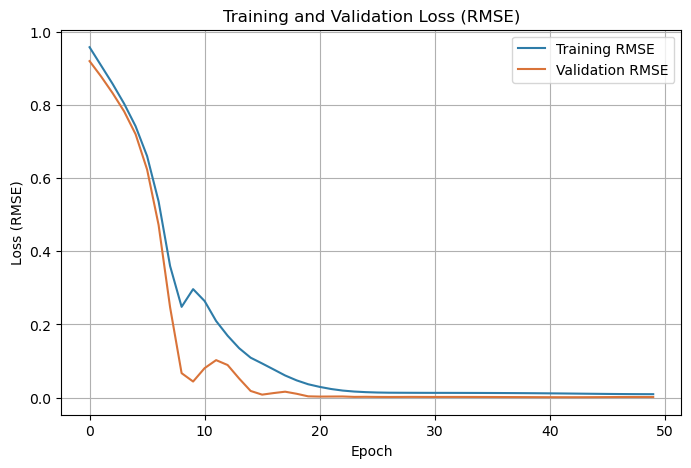

LSTM Training Loss (RMSE) for this SKU: 0.0084
Not enough training data or an error occurred.


In [ ]:
# ****** LSTM w/ TimeGAN (On one SKU) Good, Date Sequential, Train Val Loss Plot ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either input has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# TimeGAN Model for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        # Recovery network: now expects input of shape (seq_len, hidden_dim)
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        # Generator: generates latent representations from random noise.
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Supervisor: helps generate better latent representations.
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic=100):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# LSTM with TimeGAN Data Augmentation Model
# ---------------------------
def forecast_run_out_for_sku_lstm_timegan(item_data, window_size=7, forecast_horizon=5,
                                          cap_percentile=0.99,
                                          use_robust_scaler=False,
                                          additional_feature=None,
                                          use_timegan=True,
                                          num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using an LSTM 
    with TimeGAN data augmentation.
    
    Returns:
        run_out_day: Predicted run-out day (Timestamp or None).
        predictions_original: Forecasted DailyBOH values (in original scale).
        rmse_lstm: RMSE for the LSTM forecast.
        rmse_baseline: RMSE for the naive baseline forecast.
        euclid_dist: Euclidean distance between actual and forecasted values.
        pearson_corr_val: Pearson correlation coefficient.
    """
    # If 'daydate' is not a column, reset index so it becomes a column.
    if 'daydate' not in item_data.columns:
        item_data = item_data.reset_index()
    
    # 1. Prepare and sort the time series
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None

    # 2. Cap outliers on DailyBOH.
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform.
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target y.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Scale the data.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Augment with TimeGAN synthetic data if enabled.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the LSTM model (unidirectional).
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train the model with early stopping and validation split.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_ts, y_ts, epochs=50, batch_size=16, callbacks=[early_stop],
                        verbose=0, validation_split=0.2, shuffle=False)
    
    # Convert the loss values in the history dictionary to RMSE.
    train_rmse_history = np.sqrt(history.history['loss'])
    val_rmse_history = np.sqrt(history.history['val_loss'])

    plt.figure(figsize=(8, 5))
    plt.plot(train_rmse_history, label='Training RMSE', color="#2e7ca8")
    plt.plot(val_rmse_history, label='Validation RMSE', color="#d97339")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (RMSE)')
    plt.title('Training and Validation Loss (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"LSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions to original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive: repeat last observed value).
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

def plot_actual_vs_predicted(validation_dates, actual_values, predictions_original):
    """Plot the actual vs predicted DailyBOH for the validation period."""
    plt.figure(figsize=(10, 6))
    plt.plot(validation_dates, actual_values, marker='o', label='Actual DailyBOH (Capped)')
    plt.plot(validation_dates, predictions_original, marker='x', linestyle='--', color='red', label='Predicted DailyBOH')
    plt.xlabel('Date')
    plt.ylabel('DailyBOH (Capped)')
    plt.title('Actual vs. Predicted DailyBOH (Validation Period)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Usage Example: Validate on Actual Data (2024-11-23 to 2024-11-27)
# ---------------------------
# We assume that the dataset's last 5 days are exactly 2024-11-23 to 2024-11-27.
# Train on data up to 2024-11-22, and validate on the next 5 days.
sku = 2100008271  # Example SKU from your selected list
item_data = features[features['itemsku'] == sku].copy()

# Use all data up to 2024-11-22 for training.
train_end_date = '2024-11-22'
data_sorted = item_data[['daydate', 'DailyBOH']].copy().sort_values('daydate')
data_sorted.set_index('daydate', inplace=True)
train_data = data_sorted.loc[:train_end_date].copy()
test_data = data_sorted.loc[train_end_date:].copy()

validation_dates = pd.date_range(start=pd.to_datetime(train_end_date) + pd.Timedelta(days=1), periods=5, freq='D')

results = forecast_run_out_for_sku_lstm_timegan(
    item_data=train_data,
    window_size=window_size,
    forecast_horizon=5,
    cap_percentile=0.99,
    use_robust_scaler=False,
    additional_feature=None,  # Only LSTM with TimeGAN, no extra feature.
    use_timegan=True,
    num_synthetic=100
)

if results[0] is not None:
    run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = results
    print("\nValidation Results:")
    print(f"RMSE (LSTM): {rmse_lstm:.4f}")
    print(f"RMSE (Baseline): {rmse_baseline:.4f}")
    print(f"Euclidean Distance: {euclid_dist:.4f}")
    print(f"Pearson Correlation: {pearson_corr_val:.4f}")
    print(f"Predicted run-out day (if any): {run_out_day}")
    
    # Get actual values for the validation period from test_data.
    actual_values_series = test_data['DailyBOH'].copy()
    cap_value = train_data['DailyBOH'].quantile(0.99)  # same cap as training
    actual_values_series = np.where(actual_values_series > cap_value, cap_value, actual_values_series)
    actual_values_series = pd.Series(actual_values_series, index=test_data.index)
    actual_values_series = actual_values_series.loc[validation_dates]
    actual_values = actual_values_series.values
    
    # Plot the actual vs predicted.
    plot_actual_vs_predicted(validation_dates, actual_values, predictions_original)
else:
    print("Not enough training data or an error occurred.")


Epoch  1: Train Loss: 0.9173, Val Loss: 0.8459
Epoch  2: Train Loss: 0.8240, Val Loss: 0.7706
Epoch  3: Train Loss: 0.7356, Val Loss: 0.6929
Epoch  4: Train Loss: 0.6459, Val Loss: 0.6124
Epoch  5: Train Loss: 0.5502, Val Loss: 0.5184
Epoch  6: Train Loss: 0.4357, Val Loss: 0.3887
Epoch  7: Train Loss: 0.2875, Val Loss: 0.2226
Epoch  8: Train Loss: 0.1293, Val Loss: 0.0609
Epoch  9: Train Loss: 0.0616, Val Loss: 0.0045
Epoch 10: Train Loss: 0.0879, Val Loss: 0.0019
Epoch 11: Train Loss: 0.0697, Val Loss: 0.0065
Epoch 12: Train Loss: 0.0439, Val Loss: 0.0105
Epoch 13: Train Loss: 0.0286, Val Loss: 0.0079
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.


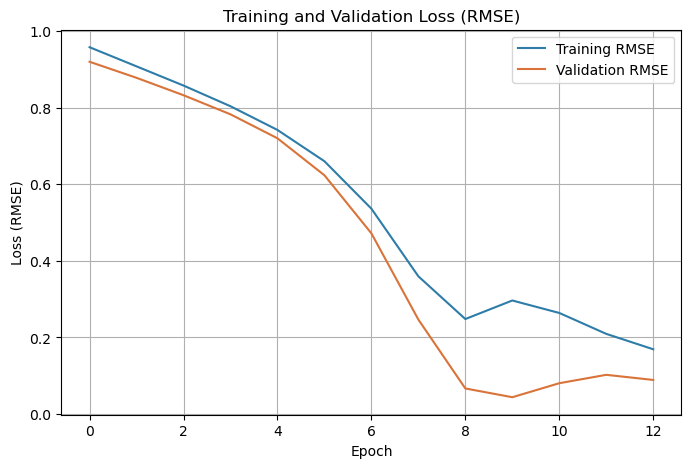

LSTM Training Loss (RMSE) for this SKU: 0.2321
Not enough training data or an error occurred.


In [ ]:
# ****** LSTM w/ TimeGAN (On one SKU) Good, Date Sequential, Train Val Loss Plot w/ early stop ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility.
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either input has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# Custom Callback to Print Losses
# ---------------------------
class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        print(f"Epoch {epoch+1:2d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# ---------------------------
# TimeGAN Model for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        # Recovery network: expects input of shape (seq_len, hidden_dim)
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        # Generator: generates latent representations from random noise.
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Supervisor: refines latent representations.
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        # Discriminator: distinguishes real vs. synthetic latent sequences.
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        # Pretrain the autoencoder for 50 epochs.
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic=100):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim])
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# LSTM with TimeGAN Data Augmentation Model
# ---------------------------
def forecast_run_out_for_sku_lstm_timegan(item_data, window_size=7, forecast_horizon=5,
                                          cap_percentile=0.99,
                                          use_robust_scaler=False,
                                          additional_feature=None,
                                          use_timegan=True,
                                          num_synthetic=100):
    """
    Forecast run-out date for a given SKU's time series of DailyBOH using an LSTM 
    with TimeGAN data augmentation.
    """
    # Ensure 'daydate' is available.
    if 'daydate' not in item_data.columns:
        item_data = item_data.reset_index()
    
    # 1. Prepare and sort the time series.
    ts_data = item_data[['daydate', 'DailyBOH']].copy()
    ts_data.sort_values("daydate", inplace=True)
    ts_data.set_index('daydate', inplace=True)
    
    if additional_feature is not None and additional_feature in item_data.columns:
        ts_data[additional_feature] = item_data.sort_values("daydate")[additional_feature].values

    if len(ts_data) <= window_size:
        return None, None, None, None, None, None

    # 2. Cap outliers on DailyBOH.
    cap_value = ts_data['DailyBOH'].quantile(cap_percentile)
    ts_data['DailyBOH_capped'] = np.where(ts_data['DailyBOH'] > cap_value, cap_value, ts_data['DailyBOH'])
    
    # 3. Apply log1p transform.
    ts_data['DailyBOH_trans'] = np.log1p(ts_data['DailyBOH_capped'])
    
    # 4. Create input matrix X and target y.
    if additional_feature is not None and additional_feature in ts_data.columns:
        feature_cols = ['DailyBOH_trans', additional_feature]
        ts_values = ts_data[feature_cols].values
    else:
        ts_values = ts_data['DailyBOH_trans'].values.reshape(-1, 1)
    
    # 5. Scale the data.
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    ts_values_scaled = scaler.fit_transform(ts_values)
    
    if ts_values_scaled.shape[1] > 1:
        target_scaled = ts_values_scaled[:, 0]
    else:
        target_scaled = ts_values_scaled.flatten()
    
    # 6. Create sliding windows.
    X_list, y_list = [], []
    for i in range(window_size, len(target_scaled)):
        if ts_values_scaled.shape[1] > 1:
            X_list.append(ts_values_scaled[i-window_size:i, :])
        else:
            X_list.append(target_scaled[i-window_size:i])
        y_list.append(target_scaled[i])
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. Augment with TimeGAN synthetic data if enabled.
    if use_timegan:
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build the LSTM model (unidirectional).
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Set up EarlyStopping (monitoring validation loss) and the LossHistory callback.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                                  restore_best_weights=True, verbose=1)
    loss_history = LossHistory()
    
    # Train the model.
    history = model.fit(X_ts, y_ts, epochs=50, batch_size=16,
                        callbacks=[early_stop, loss_history],
                        verbose=0, validation_split=0.2, shuffle=False)
    
    # Plot RMSE for training and validation.
    plt.figure(figsize=(8, 5))
    plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', color="#2e7ca8")
    plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE', color="#d97339")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (RMSE)')
    plt.title('Training and Validation Loss (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    train_loss_mse = model.evaluate(X_ts, y_ts, verbose=0)
    train_rmse = np.sqrt(train_loss_mse)
    print(f"LSTM Training Loss (RMSE) for this SKU: {train_rmse:.4f}")
    
    # 10. Forecast future inventory for the next forecast_horizon days.
    predictions_scaled = []
    if ts_values_scaled.shape[1] > 1:
        current_window = ts_values_scaled[-window_size:, :]
    else:
        current_window = ts_values_scaled[-window_size:]
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, X_ts.shape[2]), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        if ts_values_scaled.shape[1] > 1:
            last_row = current_window[-1, :].copy()
            last_row[0] = pred_value
            current_window = np.vstack([current_window[1:], last_row])
        else:
            current_window = np.append(current_window[1:], pred_value)
    
    # 11. Inverse transform predictions to original scale.
    if ts_values_scaled.shape[1] > 1:
        inv_array = []
        for pred in predictions_scaled:
            row = current_window[-1, :].copy()
            row[0] = pred
            inv_array.append(row)
        inv_array = np.array(inv_array)
    else:
        inv_array = np.array(predictions_scaled).reshape(-1, 1)
    
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast (naive: repeat last observed value).
    last_row = ts_values_scaled[-1, :]
    baseline_scaled = np.tile(last_row, (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    actual_values = ts_data['DailyBOH_capped'].tail(forecast_horizon).values
    mse_original = mean_squared_error(actual_values, predictions_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    
    rmse_lstm = np.sqrt(mse_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 13. Determine the first day when predicted inventory <= 0.
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            run_out_day = ts_data.index[-1] + pd.Timedelta(days=i+1)
            break

    return run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val

def plot_actual_vs_predicted(validation_dates, actual_values, predictions_original):
    """Plot the actual vs predicted DailyBOH for the validation period."""
    plt.figure(figsize=(10, 6))
    plt.plot(validation_dates, actual_values, marker='o', label='Actual DailyBOH (Capped)')
    plt.plot(validation_dates, predictions_original, marker='x', linestyle='--', color='red', label='Predicted DailyBOH')
    plt.xlabel('Date')
    plt.ylabel('DailyBOH (Capped)')
    plt.title('Actual vs. Predicted DailyBOH (Validation Period)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Usage Example: Validate on Actual Data
# ---------------------------
# Assume the dataset's last 5 days correspond to 2024-11-23 to 2024-11-27.
# Train on data up to 2024-11-22 and validate on the next 5 days.
sku = 2100008271  # Example SKU
# Assume 'features' is your dataframe containing the data.
item_data = features[features['itemsku'] == sku].copy()

# Use data up to 2024-11-22 for training.
train_end_date = '2024-11-22'
data_sorted = item_data[['daydate', 'DailyBOH']].copy().sort_values('daydate')
data_sorted.set_index('daydate', inplace=True)
train_data = data_sorted.loc[:train_end_date].copy()
test_data = data_sorted.loc[train_end_date:].copy()

validation_dates = pd.date_range(start=pd.to_datetime(train_end_date) + pd.Timedelta(days=1), periods=5, freq='D')

results = forecast_run_out_for_sku_lstm_timegan(
    item_data=train_data,
    window_size=7,
    forecast_horizon=5,
    cap_percentile=0.99,
    use_robust_scaler=False,
    additional_feature=None,  # Only LSTM with TimeGAN, no extra feature.
    use_timegan=True,
    num_synthetic=100
)

if results[0] is not None:
    run_out_day, predictions_original, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val = results
    print("\nValidation Results:")
    print(f"RMSE (LSTM): {rmse_lstm:.4f}")
    print(f"RMSE (Baseline): {rmse_baseline:.4f}")
    print(f"Euclidean Distance: {euclid_dist:.4f}")
    print(f"Pearson Correlation: {pearson_corr_val:.4f}")
    print(f"Predicted run-out day (if any): {run_out_day}")
    
    # Get actual values for the validation period from test_data.
    actual_values_series = test_data['DailyBOH'].copy()
    cap_value = train_data['DailyBOH'].quantile(0.99)  # Use same cap as training.
    actual_values_series = np.where(actual_values_series > cap_value, cap_value, actual_values_series)
    actual_values_series = pd.Series(actual_values_series, index=test_data.index)
    actual_values_series = actual_values_series.loc[validation_dates]
    actual_values = actual_values_series.values
    
    # Plot Actual vs Predicted.
    plot_actual_vs_predicted(validation_dates, actual_values, predictions_original)
else:
    print("Not enough training data or an error occurred.")


Validation Results:
RMSE (LSTM): 27.5355
RMSE (Baseline): 11.8322
Euclidean Distance: 61.5712
Pearson Correlation: 0.9850
Predicted run-out day (if any): None


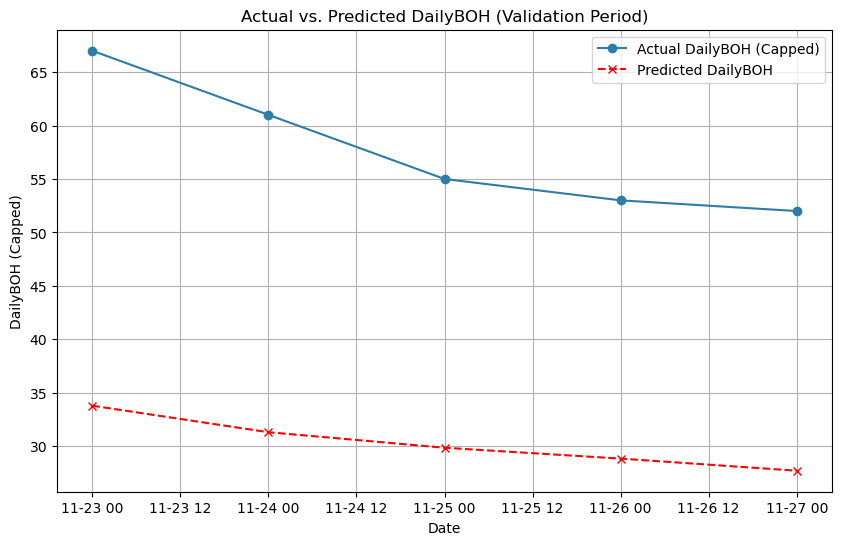

In [5]:
# ====================== ****** LSTM w/ TimeGAN (On one SKU) Good, Date Sequential ******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ---------------------------
# 1. Safe Pearson Correlation
# ---------------------------
def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# 2. TimeGAN for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic=100):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim]) 
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# 3. LSTM + TimeGAN Forecasting Function
# ---------------------------
def train_and_validate_lstm_timegan(item_data, train_end_date='2024-11-22', 
                                    forecast_horizon=5, window_size=7,
                                    cap_percentile=0.995, 
                                    use_robust_scaler=False,
                                    use_timegan=True,
                                    num_synthetic=100):
    """
    Train the LSTM+TimeGAN model on data up to train_end_date, then forecast the next forecast_horizon days
    (assumed to be 2024-11-23 to 2024-11-27 for validation). Compare the forecast with the actual data for
    that period.
    
    Returns:
        predictions_original (array): The forecasted DailyBOH in original scale for the 5 validation days.
        actual_values (array): The actual capped DailyBOH for the same 5 days.
        rmse_lstm (float): RMSE of the forecast vs. actual.
        rmse_baseline (float): RMSE of naive baseline vs. actual.
        euclid_dist (float): Euclidean distance forecast vs. actual.
        pearson_corr_val (float): Pearson correlation forecast vs. actual.
    """
    # 1. Split data into train set (up to train_end_date) and test set (the next 5 days).
    # Sort by daydate.
    data_sorted = item_data[['daydate', 'DailyBOH']].copy().sort_values('daydate')
    data_sorted.set_index('daydate', inplace=True)
    
    # Train data is up to train_end_date
    train_data = data_sorted.loc[:train_end_date].copy()
    # Test data is from the next day after train_end_date up to train_end_date + forecast_horizon days
    # i.e. 2024-11-23 to 2024-11-27
    test_data = data_sorted.loc[train_end_date:].copy()  # We'll use the last 5 days of this for comparison
    
    # 2. Check we have enough data for training
    if len(train_data) <= window_size:
        print("Not enough training data for the specified window size.")
        return None, None, None, None, None, None
    
    # 3. Cap outliers in train_data
    cap_value = train_data['DailyBOH'].quantile(cap_percentile)
    train_data['DailyBOH_capped'] = np.where(train_data['DailyBOH'] > cap_value, cap_value, train_data['DailyBOH'])
    
    # 4. log1p transform
    train_data['DailyBOH_trans'] = np.log1p(train_data['DailyBOH_capped'])
    
    # 5. Scale the train data (univariate: just DailyBOH_trans)
    train_values = train_data['DailyBOH_trans'].values.reshape(-1, 1)
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    train_values_scaled = scaler.fit_transform(train_values)
    
    # 6. Create sliding windows for train set
    X_list, y_list = [], []
    for i in range(window_size, len(train_values_scaled)):
        X_list.append(train_values_scaled[i-window_size:i, :])
        y_list.append(train_values_scaled[i, 0])  # target is the first (and only) column
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    # Reshape if needed
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. (Optional) Augment with TimeGAN
    if use_timegan:
        # shape: (n_samples, seq_len, feature_dim)
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train model
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 10. Forecast the next 'forecast_horizon' days
    # We'll use the last 'window_size' points from train_data to forecast forward
    last_window_scaled = train_values_scaled[-window_size:, :]  # shape: (window_size, 1)
    
    predictions_scaled = []
    current_window = last_window_scaled.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, 1), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        # Shift
        current_window = np.append(current_window[1:], [[pred_value]], axis=0)
    
    # 11. Inverse transform predictions
    inv_array = np.array(predictions_scaled).reshape(-1, 1)
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast
    baseline_scaled = np.tile(last_window_scaled[-1], (forecast_horizon, 1))  # shape (forecast_horizon, 1)
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    # 13. Compare with actual data from 2024-11-23 to 2024-11-27
    # Let's assume test_data includes these days; we'll take the last 'forecast_horizon' rows
    # or explicitly select by date range.
    validation_dates = pd.date_range(start=pd.to_datetime(train_end_date) + pd.Timedelta(days=1),
                                     periods=forecast_horizon, freq='D')
    
    # We'll create a small DataFrame for the test period
    test_data_sorted = test_data.sort_index()
    # The actual is the last 'forecast_horizon' days, or specifically from 2024-11-23 to 2024-11-27
    actual_values_series = test_data_sorted['DailyBOH'].copy()
    # Cap the actual test data with the same cap_value (for consistency)
    actual_values_series = np.where(actual_values_series > cap_value, cap_value, actual_values_series)
    actual_values_series = pd.Series(actual_values_series, index=test_data_sorted.index)
    # Filter only the forecast horizon range
    actual_values_series = actual_values_series.loc[validation_dates]
    
    # Ensure we have the same length
    if len(actual_values_series) != forecast_horizon:
        print("Warning: The test data does not match the expected forecast horizon exactly.")
    
    actual_values = actual_values_series.values
    
    # 14. Compute metrics
    mse_original = mean_squared_error(actual_values, predictions_original)
    rmse_lstm = np.sqrt(mse_original)
    
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # (Optional) run-out day detection (not strictly relevant for the 5-day validation, but we keep it)
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            # The last train date is train_end_date; day i+1 after that
            run_out_day = pd.to_datetime(train_end_date) + pd.Timedelta(days=i+1)
            break
    
    return (predictions_original, actual_values, rmse_lstm, rmse_baseline, 
            euclid_dist, pearson_corr_val, run_out_day, validation_dates)

def plot_validation_results(validation_dates, actual_values, predictions_original):
    """Plot the actual vs predicted for the validation period."""
    plt.figure(figsize=(10, 6))
    plt.plot(validation_dates, actual_values, marker='o', color='#2e7ca8', label='Actual DailyBOH (Capped)')
    plt.plot(validation_dates, predictions_original, marker='x', linestyle='--', color='red', label='Predicted DailyBOH')
    plt.xlabel('Date')
    plt.ylabel('DailyBOH (Capped)')
    plt.title('Actual vs. Predicted DailyBOH (Validation Period)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Usage Example for a Single SKU
# ---------------------------
sku = 7171500111  # pick one SKU for demonstration
item_data = features[features['itemsku'] == sku].copy()

results = train_and_validate_lstm_timegan(
    item_data=item_data, 
    train_end_date='2024-11-22',  # Train on data up to 2024-11-22
    forecast_horizon=5,          # Validate on 2024-11-23 to 2024-11-27
    window_size=7,
    cap_percentile=0.995,
    use_robust_scaler=False,
    use_timegan=True,
    num_synthetic=100
)

if results[0] is not None:
    (predictions_original, actual_values, rmse_lstm, rmse_baseline, 
     euclid_dist, pearson_corr_val, run_out_day, validation_dates) = results
    
    print("\nValidation Results:")
    print(f"RMSE (LSTM): {rmse_lstm:.4f}")
    print(f"RMSE (Baseline): {rmse_baseline:.4f}")
    print(f"Euclidean Distance: {euclid_dist:.4f}")
    print(f"Pearson Correlation: {pearson_corr_val:.4f}")
    print(f"Predicted run-out day (if any): {run_out_day}")
    
    # Plot the actual vs. predicted for the validation period
    plot_validation_results(validation_dates, actual_values, predictions_original)
else:
    print("Not enough data or an issue occurred during training.")


Validation Results:
RMSE (LSTM): 10.5045
RMSE (Baseline): 15.1103
Euclidean Distance: 23.4887
Pearson Correlation: 0.5495
Predicted run-out day (if any): None


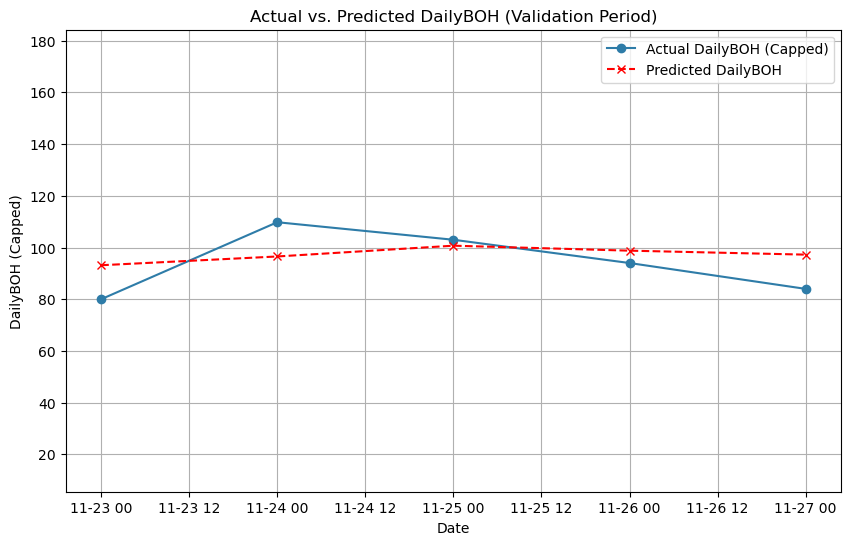

In [17]:
# ====================== ****** LSTM w/ TimeGAN (On one SKU) Good, Date Sequential ((Zoom out))******

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ---------------------------
# 1. Safe Pearson Correlation
# ---------------------------
def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# 2. TimeGAN for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic=100):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim]) 
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# 3. LSTM + TimeGAN Forecasting Function
# ---------------------------
def train_and_validate_lstm_timegan(item_data, train_end_date='2024-11-22', 
                                    forecast_horizon=5, window_size=7,
                                    cap_percentile=0.995, 
                                    use_robust_scaler=False,
                                    use_timegan=True,
                                    num_synthetic=100):
    """
    Train the LSTM+TimeGAN model on data up to train_end_date, then forecast the next forecast_horizon days
    (assumed to be 2024-11-23 to 2024-11-27 for validation). Compare the forecast with the actual data for
    that period.
    
    Returns:
        predictions_original (array): The forecasted DailyBOH in original scale for the 5 validation days.
        actual_values (array): The actual capped DailyBOH for the same 5 days.
        rmse_lstm (float): RMSE of the forecast vs. actual.
        rmse_baseline (float): RMSE of naive baseline vs. actual.
        euclid_dist (float): Euclidean distance forecast vs. actual.
        pearson_corr_val (float): Pearson correlation forecast vs. actual.
    """
    # 1. Split data into train set (up to train_end_date) and test set (the next 5 days).
    # Sort by daydate.
    data_sorted = item_data[['daydate', 'DailyBOH']].copy().sort_values('daydate')
    data_sorted.set_index('daydate', inplace=True)
    
    # Train data is up to train_end_date
    train_data = data_sorted.loc[:train_end_date].copy()
    # Test data is from the next day after train_end_date up to train_end_date + forecast_horizon days
    # i.e. 2024-11-23 to 2024-11-27
    test_data = data_sorted.loc[train_end_date:].copy()  # We'll use the last 5 days of this for comparison
    
    # 2. Check we have enough data for training
    if len(train_data) <= window_size:
        print("Not enough training data for the specified window size.")
        return None, None, None, None, None, None
    
    # 3. Cap outliers in train_data
    cap_value = train_data['DailyBOH'].quantile(cap_percentile)
    train_data['DailyBOH_capped'] = np.where(train_data['DailyBOH'] > cap_value, cap_value, train_data['DailyBOH'])
    
    # 4. log1p transform
    train_data['DailyBOH_trans'] = np.log1p(train_data['DailyBOH_capped'])
    
    # 5. Scale the train data (univariate: just DailyBOH_trans)
    train_values = train_data['DailyBOH_trans'].values.reshape(-1, 1)
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    train_values_scaled = scaler.fit_transform(train_values)
    
    # 6. Create sliding windows for train set
    X_list, y_list = [], []
    for i in range(window_size, len(train_values_scaled)):
        X_list.append(train_values_scaled[i-window_size:i, :])
        y_list.append(train_values_scaled[i, 0])  # target is the first (and only) column
    X_ts = np.array(X_list)
    y_ts = np.array(y_list)
    
    # Reshape if needed
    if X_ts.ndim == 2:
        X_ts = X_ts.reshape((X_ts.shape[0], X_ts.shape[1], 1))
    
    # 7. (Optional) Augment with TimeGAN
    if use_timegan:
        # shape: (n_samples, seq_len, feature_dim)
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, X_ts.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train model
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 10. Forecast the next 'forecast_horizon' days
    # We'll use the last 'window_size' points from train_data to forecast forward
    last_window_scaled = train_values_scaled[-window_size:, :]  # shape: (window_size, 1)
    
    predictions_scaled = []
    current_window = last_window_scaled.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, 1), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        # Shift
        current_window = np.append(current_window[1:], [[pred_value]], axis=0)
    
    # 11. Inverse transform predictions
    inv_array = np.array(predictions_scaled).reshape(-1, 1)
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast
    baseline_scaled = np.tile(last_window_scaled[-1], (forecast_horizon, 1))  # shape (forecast_horizon, 1)
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    # 13. Compare with actual data from 2024-11-23 to 2024-11-27
    # Let's assume test_data includes these days; we'll take the last 'forecast_horizon' rows
    # or explicitly select by date range.
    validation_dates = pd.date_range(start=pd.to_datetime(train_end_date) + pd.Timedelta(days=1),
                                     periods=forecast_horizon, freq='D')
    
    # We'll create a small DataFrame for the test period
    test_data_sorted = test_data.sort_index()
    # The actual is the last 'forecast_horizon' days, or specifically from 2024-11-23 to 2024-11-27
    actual_values_series = test_data_sorted['DailyBOH'].copy()
    # Cap the actual test data with the same cap_value (for consistency)
    actual_values_series = np.where(actual_values_series > cap_value, cap_value, actual_values_series)
    actual_values_series = pd.Series(actual_values_series, index=test_data_sorted.index)
    # Filter only the forecast horizon range
    actual_values_series = actual_values_series.loc[validation_dates]
    
    # Ensure we have the same length
    if len(actual_values_series) != forecast_horizon:
        print("Warning: The test data does not match the expected forecast horizon exactly.")
    
    actual_values = actual_values_series.values
    
    # 14. Compute metrics
    mse_original = mean_squared_error(actual_values, predictions_original)
    rmse_lstm = np.sqrt(mse_original)
    
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # (Optional) run-out day detection (not strictly relevant for the 5-day validation, but we keep it)
    run_out_day = None
    for i, inv in enumerate(predictions_original):
        if inv <= 0:
            # The last train date is train_end_date; day i+1 after that
            run_out_day = pd.to_datetime(train_end_date) + pd.Timedelta(days=i+1)
            break
    
    return (predictions_original, actual_values, rmse_lstm, rmse_baseline, 
            euclid_dist, pearson_corr_val, run_out_day, validation_dates)

def plot_validation_results(validation_dates, actual_values, predictions_original):
    plt.figure(figsize=(10, 6))
    plt.plot(validation_dates, actual_values, marker='o', color='#2e7ca8', label='Actual DailyBOH (Capped)')
    plt.plot(validation_dates, predictions_original, marker='x', linestyle='--', color='red', label='Predicted DailyBOH')
    plt.xlabel('Date')
    plt.ylabel('DailyBOH (Capped)')
    plt.title('Actual vs. Predicted DailyBOH (Validation Period)')
    plt.legend()
    plt.grid(True)

    # compute min/max + buffer
    y_all = np.concatenate([actual_values, predictions_original])
    y_min, y_max = y_all.min(), y_all.max()
    buffer = (y_max - y_min) * 2.5      # your 200% buffer

    lower = max(0, y_min - buffer)      # clamp at zero
    upper = y_max + buffer

    plt.ylim(lower, upper)
    plt.show()

# ---------------------------
# Usage Example for a Single SKU
# ---------------------------
sku = 7396000001  # pick one SKU for demonstration
item_data = features[features['itemsku'] == sku].copy()

results = train_and_validate_lstm_timegan(
    item_data=item_data, 
    train_end_date='2024-11-22',  # Train on data up to 2024-11-22
    forecast_horizon=5,          # Validate on 2024-11-23 to 2024-11-27
    window_size=7,
    cap_percentile=0.995,
    use_robust_scaler=False,
    use_timegan=True,
    num_synthetic=100
)

if results[0] is not None:
    (predictions_original, actual_values, rmse_lstm, rmse_baseline, 
     euclid_dist, pearson_corr_val, run_out_day, validation_dates) = results
    
    print("\nValidation Results:")
    print(f"RMSE (LSTM): {rmse_lstm:.4f}")
    print(f"RMSE (Baseline): {rmse_baseline:.4f}")
    print(f"Euclidean Distance: {euclid_dist:.4f}")
    print(f"Pearson Correlation: {pearson_corr_val:.4f}")
    print(f"Predicted run-out day (if any): {run_out_day}")
    
    # Plot the actual vs. predicted for the validation period
    plot_validation_results(validation_dates, actual_values, predictions_original)
else:
    print("Not enough data or an issue occurred during training.")

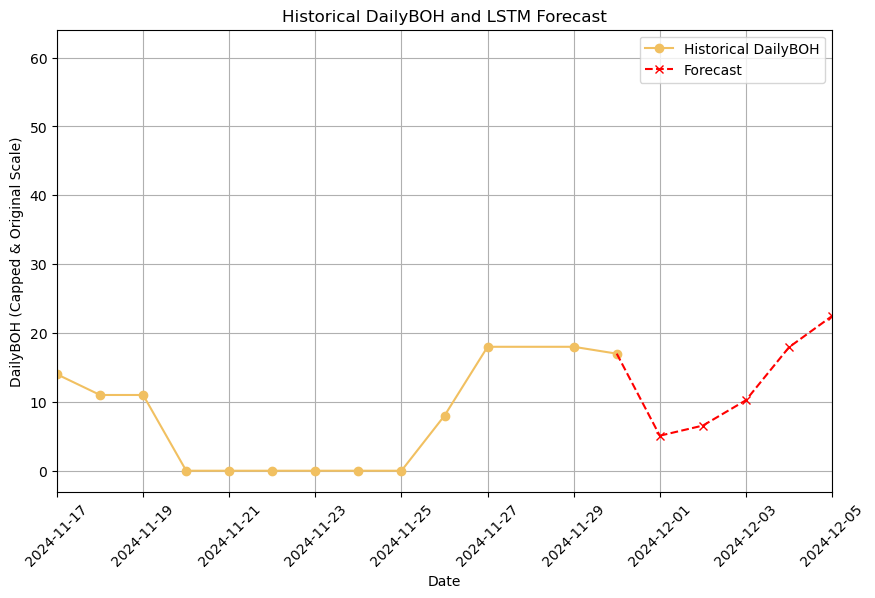

In [67]:
def plot_historical_forecast_lstm(item_data, predictions, forecast_horizon=5, window_size=14, 
                                  cap_percentile=0.995, start_date_for_plot="2024-11-17"):
    """
    Plot historical (capped) DailyBOH from 'item_data' and the forecasted values 
    from 'predictions' on the same chart, then connect the last historical point 
    to the first forecast point with a dotted line.

    Parameters:
        item_data (DataFrame): Must contain columns ['daydate', 'DailyBOH'].
        predictions (array-like): Forecasted DailyBOH values (already in original scale).
        forecast_horizon (int): Number of forecast days (used to generate x-axis dates).
        window_size (int): The window size used in training (not strictly necessary for the plot).
        cap_percentile (float): Percentile for capping outliers in historical DailyBOH.
        start_date_for_plot (str): The earliest date to show on the x-axis (YYYY-MM-DD).
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1. Sort item_data by date and set index
    data_sorted = item_data.copy()
    data_sorted.sort_values("daydate", inplace=True)
    data_sorted.set_index("daydate", inplace=True)

    # 2. Cap outliers in the historical data
    cap_value = data_sorted["DailyBOH"].quantile(cap_percentile)
    data_sorted["DailyBOH_capped"] = np.where(
        data_sorted["DailyBOH"] > cap_value, 
        cap_value, 
        data_sorted["DailyBOH"]
    )

    # 3. The historical portion is everything in 'DailyBOH_capped'
    historical = data_sorted["DailyBOH_capped"]

    # 4. Generate forecast dates: last date + 1..forecast_horizon
    last_date = historical.index[-1]
    forecast_dates = [last_date + pd.Timedelta(days=i+1) for i in range(forecast_horizon)]

    # 5. Plot historical (orange) and forecast (red)
    plt.figure(figsize=(10, 6))
    plt.plot(historical.index, historical.values, marker='o', color='#f1c061', label='Historical DailyBOH')
    plt.plot(forecast_dates, predictions, marker='x', linestyle='--', color='red', label='Forecast')

    # 5.1 Connect the last historical point to the first forecast point with a dotted line
    if forecast_dates and len(predictions) > 0:
        last_hist_value = historical.iloc[-1]
        plt.plot(
            [last_date, forecast_dates[0]], 
            [last_hist_value, predictions[0]], 
            color='red', 
            linestyle='--',  # dotted line
            marker='',
            label='_nolegend_'  # Avoid adding extra legend entry
        )

    # 6. Axis labels and title
    plt.xlabel("Date")
    plt.ylabel("DailyBOH (Capped & Original Scale)")
    plt.title("Historical DailyBOH and LSTM Forecast")
    plt.legend()
    plt.grid(True)

    # 7. Set x-axis limit to start from the desired date
    start_date_obj = pd.to_datetime(start_date_for_plot)
    end_date_obj = forecast_dates[-1] if forecast_dates else last_date
    plt.xlim([start_date_obj, end_date_obj])

    # 8. Rotate date labels by 45 degrees
    plt.xticks(rotation=45)

    plt.show()

plot_historical_forecast_lstm(
    item_data=item_data, 
    predictions=predictions_original, 
    forecast_horizon=5, 
    window_size=14, 
    cap_percentile=0.995
)

Plotting PCA of real vs. synthetic windows (flattened).


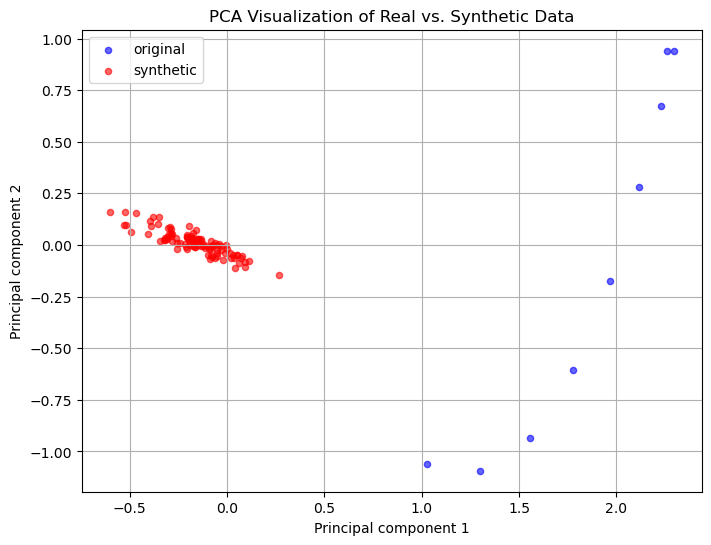


Validation Results:
RMSE (LSTM): 22.3824
RMSE (Baseline): 16.3890
Euclidean Distance: 50.0485
Pearson Correlation: 0.9859


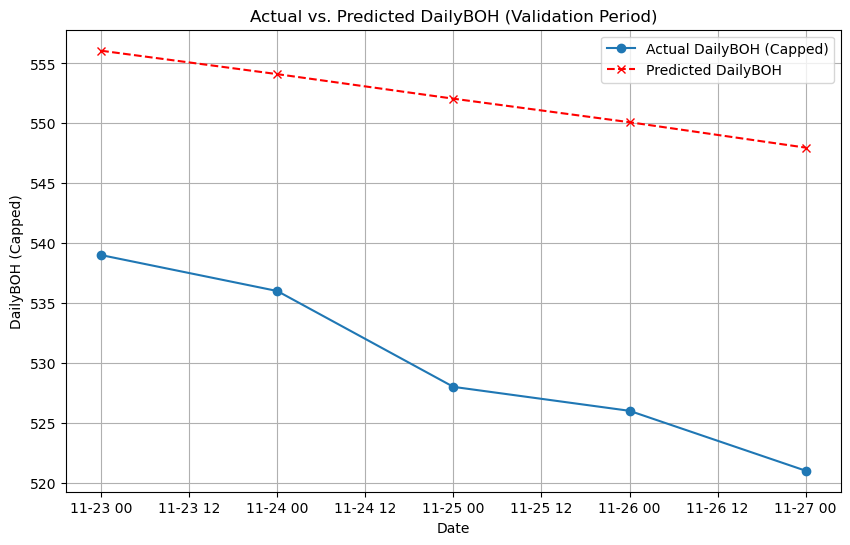

In [ ]:
# ====================== ****** LSTM w/ TimeGAN PCA Viz (pic not good) ******

import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# ---------------------------
# 0. Set Seeds for Reproducibility
# ---------------------------
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ---------------------------
# 1. Safe Pearson Correlation
# ---------------------------
def safe_pearson_corr(a, b):
    """Compute Pearson correlation safely; return np.nan if either vector has zero variance."""
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

# ---------------------------
# 2. TimeGAN for Data Augmentation
# ---------------------------
class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        # Updated embedder: both LSTM layers now return sequences.
        self.embedder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.feature_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)
        ])
        self.recovery = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.feature_dim))
        ])
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.supervisor = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hidden_dim, activation='tanh'))
        ])
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.seq_len, self.hidden_dim)),
            tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Combine embedder and recovery as an autoencoder for pretraining.
        self.autoencoder = tf.keras.Sequential([self.embedder, self.recovery])
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

    def pretrain(self, X, epochs=50, batch_size=128):
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

    def generate(self, n_samples):
        random_noise = np.random.normal(size=(n_samples, self.seq_len, self.hidden_dim))
        generated_latent = self.generator.predict(random_noise, verbose=0)
        supervised_latent = self.supervisor.predict(generated_latent, verbose=0)
        synthetic_series = self.recovery.predict(supervised_latent, verbose=0)
        return synthetic_series

def augment_with_timegan(real_data, seq_len, num_synthetic=100):
    """
    Train TimeGAN on real_data (shape: [n_samples, seq_len, feature_dim]) 
    and generate synthetic time series.
    """
    feature_dim = real_data.shape[2]
    timegan = TimeGAN(seq_len=seq_len, feature_dim=feature_dim, hidden_dim=24, num_layers=3, learning_rate=0.001)
    timegan.pretrain(real_data, epochs=50, batch_size=128)
    synthetic_data = timegan.generate(n_samples=num_synthetic)
    return synthetic_data

# ---------------------------
# 3. Visualization: PCA for Real vs Synthetic
# ---------------------------
def visualize_timegan_pca(real_data, synthetic_data):
    """
    Visualize real vs. synthetic time-series data in 2D using PCA.
    
    Parameters:
        real_data (numpy_ndarray): Real data of shape (num_samples, seq_len, feature_dim).
        synthetic_data (numpy_ndarray): Synthetic data of shape (num_samples, seq_len, feature_dim).
    """
    # 1. Flatten each window from (seq_len, feature_dim) -> (seq_len*feature_dim,)
    num_real = real_data.shape[0]
    seq_len = real_data.shape[1]
    feature_dim = real_data.shape[2]

    num_synth = synthetic_data.shape[0]

    real_flat = real_data.reshape(num_real, seq_len * feature_dim)
    synth_flat = synthetic_data.reshape(num_synth, seq_len * feature_dim)

    # 2. Combine for PCA
    combined = np.concatenate([real_flat, synth_flat], axis=0)

    # 3. PCA -> 2 components
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    combined_2d = pca.fit_transform(combined)

    real_2d = combined_2d[:num_real]
    synth_2d = combined_2d[num_real:]

    # 4. Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], alpha=0.6, label='original', color='blue', s=20)
    plt.scatter(synth_2d[:, 0], synth_2d[:, 1], alpha=0.6, label='synthetic', color='red', s=20)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title('PCA Visualization of Real vs. Synthetic Data')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# 4. LSTM + TimeGAN Forecasting + Validation
# ---------------------------
def train_and_validate_lstm_timegan(item_data, train_end_date='2024-11-22', 
                                    forecast_horizon=5, window_size=14,
                                    cap_percentile=0.995, 
                                    use_robust_scaler=False,
                                    use_timegan=True,
                                    num_synthetic=100,
                                    plot_pca=False):
    """
    Train the LSTM+TimeGAN model on data up to train_end_date, then forecast the next forecast_horizon days
    and compare the forecast with the actual data for that period. Optionally visualize PCA of real vs. synthetic.
    
    Returns:
        predictions_original (array): The forecasted DailyBOH in original scale for the validation days.
        actual_values (array): The actual capped DailyBOH for the same days.
        rmse_lstm (float): RMSE of the forecast vs. actual.
        rmse_baseline (float): RMSE of naive baseline vs. actual.
        euclid_dist (float): Euclidean distance forecast vs. actual.
        pearson_corr_val (float): Pearson correlation forecast vs. actual.
    """
    # 1. Sort data and split by train_end_date
    data_sorted = item_data[['daydate', 'DailyBOH']].copy().sort_values('daydate')
    data_sorted.set_index('daydate', inplace=True)
    
    # Train data up to train_end_date
    train_data = data_sorted.loc[:train_end_date].copy()
    # Test data from train_end_date onward
    test_data = data_sorted.loc[train_end_date:].copy()
    
    # 2. Check enough training data
    if len(train_data) <= window_size:
        print("Not enough training data for the specified window size.")
        return None, None, None, None, None, None
    
    # 3. Cap outliers
    cap_value = train_data['DailyBOH'].quantile(cap_percentile)
    train_data['DailyBOH_capped'] = np.where(train_data['DailyBOH'] > cap_value, cap_value, train_data['DailyBOH'])
    
    # 4. log1p transform
    train_data['DailyBOH_trans'] = np.log1p(train_data['DailyBOH_capped'])
    
    # 5. Scale
    train_values = train_data['DailyBOH_trans'].values.reshape(-1, 1)
    scaler = RobustScaler() if use_robust_scaler else MinMaxScaler(feature_range=(0, 1))
    train_values_scaled = scaler.fit_transform(train_values)
    
    # 6. Create sliding windows for training
    X_list, y_list = [], []
    for i in range(window_size, len(train_values_scaled)):
        X_list.append(train_values_scaled[i-window_size:i, :])
        y_list.append(train_values_scaled[i, 0])
    X_ts = np.array(X_list)  # shape: (n_samples, window_size, 1)
    y_ts = np.array(y_list)
    
    # (Optional) PCA visualization data placeholders
    real_data_for_pca = None
    synthetic_data_for_pca = None

    # 7. TimeGAN augmentation
    if use_timegan:
        # shape (n_samples, seq_len=window_size, feature_dim=1)
        real_data_for_pca = X_ts.copy()  # keep a copy for pca
        synthetic_data = augment_with_timegan(X_ts, seq_len=window_size, num_synthetic=num_synthetic)
        synthetic_data_for_pca = synthetic_data.copy()
        # Combine
        X_ts = np.concatenate([X_ts, synthetic_data], axis=0)
        synthetic_targets = np.full((num_synthetic,), y_ts.mean())
        y_ts = np.concatenate([y_ts, synthetic_targets], axis=0)
    
    # 8. Build LSTM
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 9. Train
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_ts, y_ts, epochs=20, batch_size=16, callbacks=[early_stop], verbose=0)
    
    # 10. Forecast the next 'forecast_horizon' days
    last_window_scaled = train_values_scaled[-window_size:, :]
    predictions_scaled = []
    current_window = last_window_scaled.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(current_window.reshape(1, window_size, 1), verbose=0)
        pred_value = pred[0, 0]
        predictions_scaled.append(pred_value)
        current_window = np.append(current_window[1:], [[pred_value]], axis=0)
    
    # 11. Inverse transform predictions
    inv_array = np.array(predictions_scaled).reshape(-1, 1)
    predictions_transformed = scaler.inverse_transform(inv_array)[:, 0]
    predictions_original = np.expm1(predictions_transformed)
    
    # 12. Baseline forecast
    baseline_scaled = np.tile(last_window_scaled[-1], (forecast_horizon, 1))
    baseline_inv = scaler.inverse_transform(baseline_scaled)[:, 0]
    baseline_original = np.expm1(baseline_inv)
    
    # 13. Actual values for validation
    validation_dates = pd.date_range(start=pd.to_datetime(train_end_date) + pd.Timedelta(days=1),
                                     periods=forecast_horizon, freq='D')
    test_data_sorted = test_data.sort_index()
    actual_values_series = test_data_sorted['DailyBOH'].copy()
    actual_values_series = np.where(actual_values_series > cap_value, cap_value, actual_values_series)
    actual_values_series = pd.Series(actual_values_series, index=test_data_sorted.index)
    actual_values_series = actual_values_series.loc[validation_dates]
    
    if len(actual_values_series) != forecast_horizon:
        print("Warning: The test data does not match the expected forecast horizon exactly.")
    
    actual_values = actual_values_series.values
    
    # 14. Compute metrics
    mse_original = mean_squared_error(actual_values, predictions_original)
    rmse_lstm = np.sqrt(mse_original)
    mse_baseline = mean_squared_error(actual_values, baseline_original)
    rmse_baseline = np.sqrt(mse_baseline)
    
    euclid_dist = np.linalg.norm(actual_values - predictions_original)
    pearson_corr_val = safe_pearson_corr(actual_values, predictions_original)
    
    # 15. PCA Visualization if plot_pca=True
    if plot_pca and use_timegan and real_data_for_pca is not None and synthetic_data_for_pca is not None:
        print("Plotting PCA of real vs. synthetic windows (flattened).")
        visualize_timegan_pca(real_data_for_pca, synthetic_data_for_pca)
    
    return (predictions_original, actual_values, rmse_lstm, rmse_baseline, 
            euclid_dist, pearson_corr_val, validation_dates)

def plot_validation_results(validation_dates, actual_values, predictions_original):
    """Plot the actual vs predicted for the validation period."""
    plt.figure(figsize=(10, 6))
    plt.plot(validation_dates, actual_values, marker='o', label='Actual DailyBOH (Capped)')
    plt.plot(validation_dates, predictions_original, marker='x', linestyle='--', color='red', label='Predicted DailyBOH')
    plt.xlabel('Date')
    plt.ylabel('DailyBOH (Capped)')
    plt.title('Actual vs. Predicted DailyBOH (Validation Period)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Usage Example for a Single SKU
# ---------------------------
sku = 2100008271
item_data = features[features['itemsku'] == sku].copy()

results = train_and_validate_lstm_timegan(
    item_data=item_data, 
    train_end_date='2024-11-22',  # Train on data up to 2024-11-22
    forecast_horizon=5,          # Validate on 2024-11-23 to 2024-11-27
    window_size=14,
    cap_percentile=0.995,
    use_robust_scaler=False,
    use_timegan=True,
    num_synthetic=100,
    plot_pca=True  # Enabling PCA visualization of real vs synthetic windows
)

if results[0] is not None:
    predictions_original, actual_values, rmse_lstm, rmse_baseline, euclid_dist, pearson_corr_val, validation_dates = results
    
    print("\nValidation Results:")
    print(f"RMSE (LSTM): {rmse_lstm:.4f}")
    print(f"RMSE (Baseline): {rmse_baseline:.4f}")
    print(f"Euclidean Distance: {euclid_dist:.4f}")
    print(f"Pearson Correlation: {pearson_corr_val:.4f}")
    
    plot_validation_results(validation_dates, actual_values, predictions_original)
else:
    print("Not enough data or an issue occurred during training.")
